Katarzyna Kleczkowska (s24558)

Adam Sitko (s25551)

---

#**PRZEWIDYWANIE ZAKAŻENIA COVID-19 W POLSCE**

---

##**1. WGRANIE DANYCH I PRZYGOTOWANIE DO ANALIZY**

In [207]:
# Import bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from IPython.display import Image, display
from datetime import datetime, timedelta
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from math import sqrt

In [208]:
# Podgląd dokumentu
df = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/nationalcasedeath_eueea_daily_ei/csv')
df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp
0,23/10/2022,23,10,2022,3557.0,0.0,Austria,AT,AUT,8901064,Europe
1,22/10/2022,22,10,2022,5494.0,4.0,Austria,AT,AUT,8901064,Europe
2,21/10/2022,21,10,2022,7776.0,4.0,Austria,AT,AUT,8901064,Europe
3,20/10/2022,20,10,2022,8221.0,6.0,Austria,AT,AUT,8901064,Europe
4,19/10/2022,19,10,2022,10007.0,8.0,Austria,AT,AUT,8901064,Europe


In [209]:
# Całkowita liczba rekordów
entries = len(df.index)
print("Całkowita liczba rekordów: {}".format(entries))

Całkowita liczba rekordów: 28729


In [210]:
# Informacje na temat krajów uwzględnionych w badaniu
num_of_countries = df['countriesAndTerritories'].nunique()
unique_countries = df['countriesAndTerritories'].unique()
unique_continents = df['continentExp'].unique()

print(f"Liczba unikatowych krajów uwzględnionych w badaniu: {num_of_countries}")
print("\n")
print("Kraje uwzględnione w badaniu:")
print(*unique_countries, sep='\n')
print("\n")
print("Kontynenty uwzględnione w badaniu: {}".format(*unique_continents))

Liczba unikatowych krajów uwzględnionych w badaniu: 30


Kraje uwzględnione w badaniu:
Austria
Belgium
Bulgaria
Croatia
Cyprus
Czechia
Denmark
Estonia
Finland
France
Germany
Greece
Hungary
Iceland
Ireland
Italy
Latvia
Liechtenstein
Lithuania
Luxembourg
Malta
Netherlands
Norway
Poland
Portugal
Romania
Slovakia
Slovenia
Spain
Sweden


Kontynenty uwzględnione w badaniu: Europe


In [211]:
# Typy danych w poszczególnych kolumnach
df.dtypes

dateRep                     object
day                          int64
month                        int64
year                         int64
cases                      float64
deaths                     float64
countriesAndTerritories     object
geoId                       object
countryterritoryCode        object
popData2020                  int64
continentExp                object
dtype: object

In [212]:
# Zmiana formatu daty
df["dateRep"] = pd.to_datetime(df["dateRep"], format = '%d/%m/%Y').dt.date
df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp
0,2022-10-23,23,10,2022,3557.0,0.0,Austria,AT,AUT,8901064,Europe
1,2022-10-22,22,10,2022,5494.0,4.0,Austria,AT,AUT,8901064,Europe
2,2022-10-21,21,10,2022,7776.0,4.0,Austria,AT,AUT,8901064,Europe
3,2022-10-20,20,10,2022,8221.0,6.0,Austria,AT,AUT,8901064,Europe
4,2022-10-19,19,10,2022,10007.0,8.0,Austria,AT,AUT,8901064,Europe


In [213]:
# Sprawdzenie poprawności konwersji
sample_date = df.iloc[0,0]
print(f"Przykładowa data: {sample_date}")
print(f"Typ danych: {type(sample_date)}")

Przykładowa data: 2022-10-23
Typ danych: <class 'datetime.date'>


In [214]:
# Sortowanie po dacie (od najstarszych do najnowszych danych)
df.sort_values(by='dateRep', ascending = True, inplace = True)
df.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
df

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp
0,2020-01-01,1,1,2020,1.0,0.0,Finland,FI,FIN,5525292,Europe
1,2020-01-01,1,1,2020,1.0,0.0,Spain,ES,ESP,47332614,Europe
2,2020-01-02,2,1,2020,1.0,0.0,Germany,DE,DEU,83166711,Europe
3,2020-01-02,2,1,2020,0.0,0.0,Finland,FI,FIN,5525292,Europe
4,2020-01-02,2,1,2020,0.0,0.0,Spain,ES,ESP,47332614,Europe
...,...,...,...,...,...,...,...,...,...,...,...
28724,2022-10-25,25,10,2022,641.0,3.0,Latvia,LV,LVA,1907675,Europe
28725,2022-10-25,25,10,2022,1181.0,21.0,Poland,PL,POL,37958138,Europe
28726,2022-10-25,25,10,2022,0.0,0.0,Hungary,HU,HUN,9769526,Europe
28727,2022-10-25,25,10,2022,0.0,NaN,Czechia,CZ,CZE,10693939,Europe


In [215]:
# Ustalenie zakresu czasowego obserwacji
latest_date = df['dateRep'].max()
earliest_date = df['dateRep'].min()
latest_date_countries = df[df['dateRep'] == latest_date]['countriesAndTerritories']
earliest_date_countries = df[df['dateRep'] == earliest_date]['countriesAndTerritories']

print(f"Najstarsza data w pliku: {earliest_date}. Obserwacje z tego dnia pochodzą z państw: ", end='')
print(*earliest_date_countries, sep=', ')
print(f"Najnowsza data w pliku: {latest_date}. Obserwacje z tego dnia pochodzą z państw: ", end='')
print(*latest_date_countries, sep=', ')

Najstarsza data w pliku: 2020-01-01. Obserwacje z tego dnia pochodzą z państw: Finland, Spain
Najnowsza data w pliku: 2022-10-26. Obserwacje z tego dnia pochodzą z państw: Hungary


##**2. ANALIZA STATYSTYCZNA**

##**2.1. Funkcje pomocnicze**

Na potrzeby analizy statystycznej stworzono funkcje pomocnicze:


*   `draw_barplot` - funkcja tworząca wykres słupkowy dla danego df
*   `create_window_df` - funkcja tworząca dataframe zawierający dane dotyczące średniej liczby zakażeń z okna czasowego o długości *interval*
*   `draw_window_plot` - funkcja tworząca wykres liniowy dla średniej liczby zakażeń z okna czasowego oraz wykres słupkowy liczby zakażeń dla poszczególnych dni stanowiący tło dla wykresu liniowego
*   `wave_candidates` - funkcja tworząca dataframe dla 2-tygodniowego okresu czasu wokół wybranej daty, który służy do odnalezienia daty z największym wzrostem/wpadkiem w liczbie zakażeń (dla średniej z okna czasowego)
*   `wave_stats` - funkcja wyliczająca podstawowe statystyki dla wybranego przedziału czasu (docelowo poszczególnych fal pandemii)
*   `create_wave_df` - funkcja filtrująca dataframe na podstawie wybranego przedziału czasu

In [216]:
# Funkcja tworząca wykres słupkowy dla surowych danych
def draw_barplot(df, xticks_freq='2M'):
    # określenie z których dni pochodzą pierwsze i ostatnie dane
    latest_date = df['dateRep'].max()
    earliest_date = df['dateRep'].min()
    # tworzenie znaczników dla osi X
    dates_xticks = pd.date_range(earliest_date, latest_date , freq=xticks_freq) + pd.offsets.MonthBegin(1)
    dates_xticks = dates_xticks.tolist()
    dates_xticks = list(map(lambda x: x.to_pydatetime().date(), dates_xticks))
    dates_xindex = df_pol.index[df_pol['dateRep'].apply(lambda d: d in dates_xticks)]
    dates_xlabels = list(map(lambda x: x.strftime('%B %Y'), dates_xticks))
    # tworzenie wykresu słupkowego
    fig, ax = plt.subplots(figsize=(18, 10))
    sns.barplot(x='dateRep', y='cases', data=df, ax=ax, color='red', width=1, alpha=0.8)
    ax.set(title='Number of COVID-19 Cases in Poland', xlabel='Date', ylabel='Cases')
    ax.set_xticks(dates_xindex)
    ax.set_xticklabels(dates_xlabels, rotation=45)
    plt.show()

# Funkcja tworząca nowy dataframe uwzględniający dane z okna czasowego o długości 'interval'
def create_window_df(df, interval=7):
    # tworzenie atrybutów dotyczących okna czasowego
    mean = df['cases'].rolling(interval).mean()
    median = df['cases'].rolling(interval).median()
    min = df['cases'].rolling(interval).min()
    max = df['cases'].rolling(interval).max()
    dif = max - min
    # kolumna z procentowym wzrostem średniej
    prev_day_mean = pd.concat([pd.Series([np.nan]), mean.iloc[:-1]])
    prev_day_mean.reset_index(drop=True, inplace=True)
    mean_change = 100 * (mean - prev_day_mean) / prev_day_mean
    # tworzenie kolumny z liczbą przypadków z dnia następnego, która zostanie dodana do tabeli jako atrybut docelowy (label)
    next_day_cases = df['cases'].copy()[1:]
    next_day_cases.reset_index(drop=True, inplace=True)
    # tworzenie dataframe
    df_window = pd.DataFrame({'date': df['dateRep'].copy(),
                              'cases': df['cases'].copy(),
                              'mean_change_perc': mean_change,
                              'rolling_mean': mean,
                              'rolling_median': median,
                              'rolling_min': min,
                              'rolling_max': max,
                              'rolling_difference': dif,
                              'next_day_cases': next_day_cases
                              })
    # usuwanie wierszy zawierających brakujące dane w kolumnie 'rolling_mean'
    df_window = df_window[df_window['rolling_mean'].notna()]
    df_window.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
    # dodanie do dataframe atrybut informujący do wielkości okienka
    df_window.interval = interval
    return df_window

# Funkcja tworząca wykres wykres liniowy dla średniej z okienka czasowego
# wraz z wykresem słupkowym dla surowych danych stanowiący tło
def draw_window_plot(df, xticks_freq='2M', interval=7, plot_title='Number of COVID-19 Cases in Poland'):
    df.reset_index(drop=True, inplace=True)
    # określenie z których dni pochodzą pierwsze i ostatnie dane
    latest_date = df['date'].max()
    earliest_date = df['date'].min()
    # tworzenie znaczników dla osi X
    dates_xticks = pd.date_range(earliest_date, latest_date , freq=xticks_freq) + pd.offsets.MonthBegin(1)
    dates_xticks = dates_xticks.tolist()
    dates_xticks = list(map(lambda x: x.to_pydatetime().date(), dates_xticks))
    dates_xindex = df.index[df['date'].apply(lambda x: x in dates_xticks)]
    dates_xlabels = list(map(lambda x: x.strftime('%B %Y'), dates_xticks))
    # tworzenie wykresu słupkowego jako tło oraz wykres liniowy dla średniej z poprzednich dni
    fig, ax = plt.subplots(figsize=(18, 10))
    sns.lineplot(x=df.index, y='rolling_mean', data=df, color='red', label=f'{df.interval}-day average')
    sns.barplot(x=df.index, y='cases', data=df, color='red', width=1, alpha=0.2, label='New cases')
    ax.set(title=plot_title, xlabel='Date', ylabel='Cases')
    ax.set_xticks(dates_xindex)
    ax.set_xticklabels(dates_xlabels, rotation=45)
    ax.legend(loc=0)
    plt.show()

# Funkcja tworząca dataframe pomocny przy określaniu największego spadku/wzrostu zachorowań w okolicach wybranej daty
def wave_candidates(df, start_date):
    # punktem startowym jest data wyznaczona przez Suligowskiego i Ciupę
    starting_point = datetime.strptime(start_date, "%Y-%m-%d").date()
    beginning_of_array = starting_point - timedelta(days=7)
    end_of_array = starting_point + timedelta(days=7)
    # filtrowanie dni branych pod uwagę jako możliwy początek fali pandemii
    df_wave_start_candidates = df[(df["date"] >= beginning_of_array) & (df["date"] <= end_of_array)]
    return df_wave_start_candidates[['date', 'cases', 'rolling_mean', 'mean_change_perc']]

# Funkcja tworząca statystyki dla wybranego okresu czasu
def wave_stats(df, start_date, end_date):
    # określenie zakresu czasu
    start_date = datetime.strptime(start_date, "%Y-%m-%d").date()
    end_date = datetime.strptime(end_date, "%Y-%m-%d").date()
    # filtrowanie dataframe po wyznaczonych datach i tworzenie array z liczby zachorowań dla wszystkich dni
    df_wave = df[(df["date"] >= start_date) & (df["date"] <= end_date)].copy()
    cases_wave = df_wave["cases"].values
    # wskaźniki statystyczne dla wybranego okresu czasu
    wave_min = df_wave['cases'].min()
    wave_max = df_wave['cases'].max()
    wave_mean = df_wave['cases'].mean().round(2)
    wave_median = df_wave['cases'].median().round(2)
    wave_low_quartile = df_wave['cases'].quantile(q=0.25).round(2)
    wave_up_quartile = df_wave['cases'].quantile(q=0.75).round(2)
    # wypisanie wskaźników
    print(f"{'Najniższa liczba zachorowań w tej fali (min):':<50} {wave_min:>10.2f}")
    print(f"{'Najwyższa liczba zachorowań w tej fali (max):':<50} {wave_max:>10.2f}")
    print(f"{'Średnia liczba zachorowań w tej fali (mean):':<50} {wave_mean:>10.2f}")
    print(f"{'Mediana liczby zachorowań w tej fali (median):':<50} {wave_median:>10.2f}")
    print(f"{'Dolny kwartyl tej fali:':<50} {wave_low_quartile:>10.2f}")
    print(f"{'Górny kwartyl tej fali:':<50} {wave_up_quartile:>10.2f}")
    return wave_min, wave_max, wave_mean, wave_median, wave_low_quartile, wave_up_quartile

# Funkcja tworząca dataframe dla wybranego okresu czasu
def create_wave_df(df, wave_start, wave_end):
    # określenie okresu czasu
    wave_start = datetime.strptime(wave_start, "%Y-%m-%d").date()
    wave_end = datetime.strptime(wave_end, "%Y-%m-%d").date()
    # dataframe dla wybranego okresu
    df_wave = df[(df['date'] >= wave_start) & (df['date'] <= wave_end)].copy()
    df_wave.interval = df.interval
    return df_wave

##**2.2. Przefiltrowanie danych dotyczących Polski**

In [217]:
# Dataframe dla Polski
df_pol = df[df['countryterritoryCode'] == 'POL']
df_pol.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp
390,2020-03-04,4,3,2020,1.0,0.0,Poland,PL,POL,37958138,Europe
426,2020-03-05,5,3,2020,0.0,0.0,Poland,PL,POL,37958138,Europe
450,2020-03-06,6,3,2020,4.0,0.0,Poland,PL,POL,37958138,Europe
486,2020-03-07,7,3,2020,1.0,0.0,Poland,PL,POL,37958138,Europe
500,2020-03-08,8,3,2020,5.0,0.0,Poland,PL,POL,37958138,Europe


In [218]:
# Resetowanie indexu
df_pol.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
df_pol

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp
0,2020-03-04,4,3,2020,1.0,0.0,Poland,PL,POL,37958138,Europe
1,2020-03-05,5,3,2020,0.0,0.0,Poland,PL,POL,37958138,Europe
2,2020-03-06,6,3,2020,4.0,0.0,Poland,PL,POL,37958138,Europe
3,2020-03-07,7,3,2020,1.0,0.0,Poland,PL,POL,37958138,Europe
4,2020-03-08,8,3,2020,5.0,0.0,Poland,PL,POL,37958138,Europe
...,...,...,...,...,...,...,...,...,...,...,...
961,2022-10-21,21,10,2022,937.0,24.0,Poland,PL,POL,37958138,Europe
962,2022-10-22,22,10,2022,901.0,14.0,Poland,PL,POL,37958138,Europe
963,2022-10-23,23,10,2022,166.0,0.0,Poland,PL,POL,37958138,Europe
964,2022-10-24,24,10,2022,153.0,0.0,Poland,PL,POL,37958138,Europe


In [219]:
# Liczba rekordów dla Polski
entries_pol = len(df_pol.index)
print(f"Całkowita liczba rekordów: {entries_pol}")

Całkowita liczba rekordów: 966


In [220]:
# Ustalenie zakresu czasowego obserwacji dla Polski
latest_date_pol = df_pol['dateRep'].max()
earliest_date_pol = df_pol['dateRep'].min()

print(f"Najstarsza data obserwacji w Polsce: {earliest_date_pol}")
print(f"Najnowsza data obserwacji w Polsce: {latest_date_pol}")

Najstarsza data obserwacji w Polsce: 2020-03-04
Najnowsza data obserwacji w Polsce: 2022-10-25


##**2.3. Wykres nowych przypadków zakażenia względem czasu**

###**a) wykres dla surowych danych**


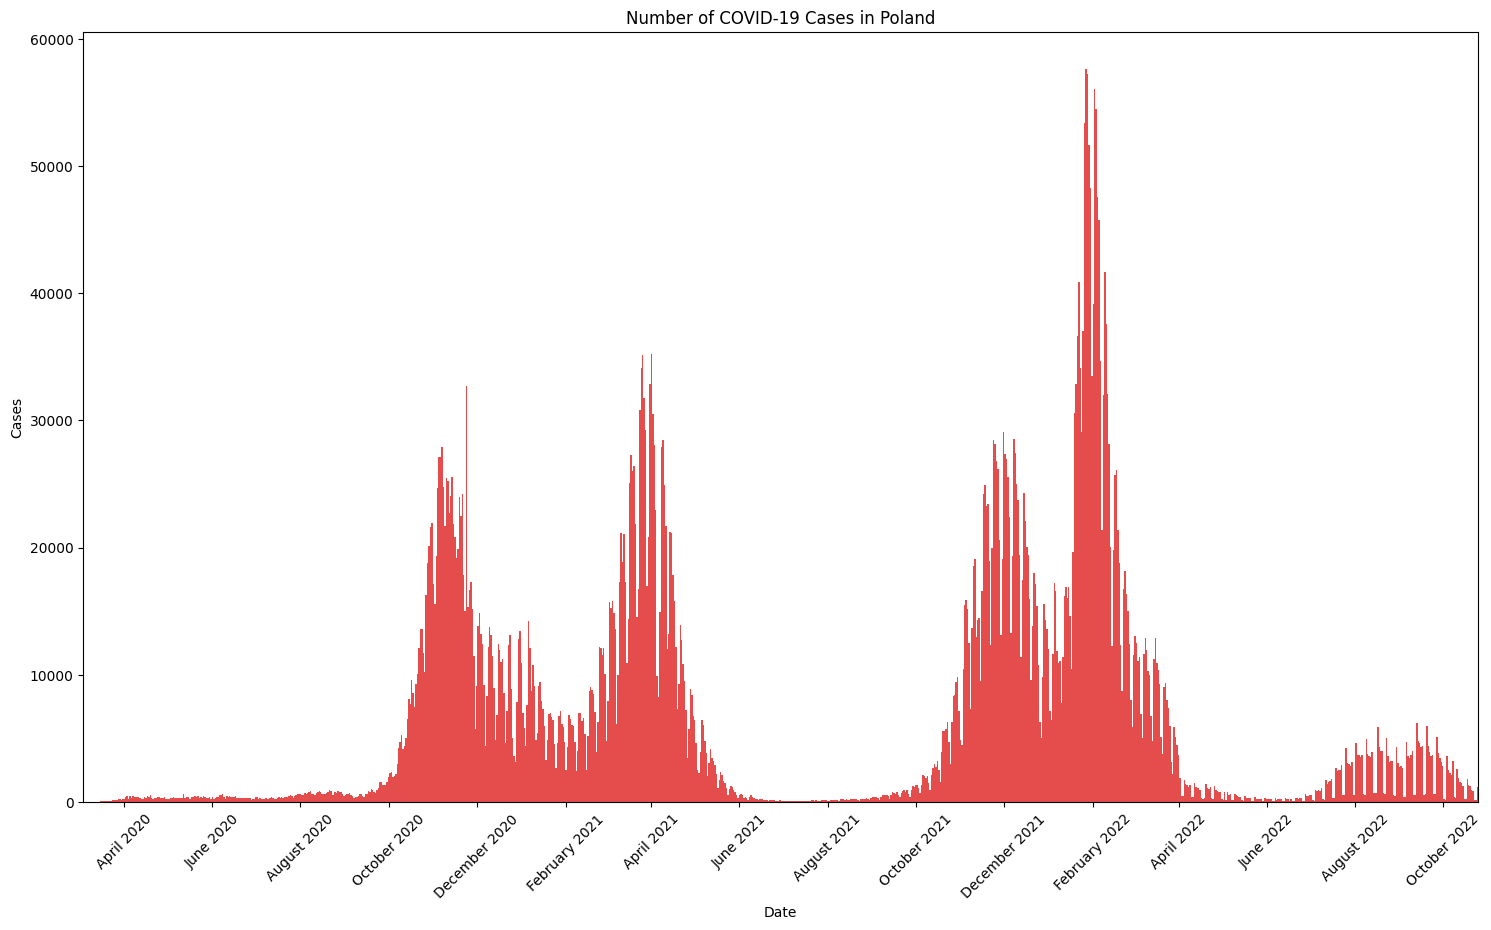

In [221]:
draw_barplot(df_pol)

Pobieżna analiza wykresu sugeruje istnienie pięciu fal pandemii, których początek wyznaczony jest przez gwałtowny wzrost dziennej liczby zachorowań, a koniec - przez ich nagły spadek. Analiza wykresu "na oko", na surowych danych wiąże się jednak z kilkoma problemami. Po pierwsze, w Polsce za pierwszą falę pandemii uznaje się początkowy okres rozwoju epidemii, który jest słabo widoczny na wykresie ze względu na to, że zachorowań było wówczas bez porównania mniej niż w późniejszych miesiącach. Po drugie, wykres jest postrzępiony ze względu na różnice w rejestrowaniu przypadków (np. wyraźnie mniej w weekendy).

W naszych badanich uznajemy, że w Polsce było sześć fal pandemii, odnosząc się do tekstu Romana Suligowskiego i Tadeusza Ciupy "Five waves of the COVID-19 pandemic and green–blue spaces in urban and rural areas in Poland" (2023), który obejmuje okres od kwietnia 2020 do maja 2022, oraz wyznaczając szóstą falę na bazie wzrostu zachorowań w drugiej połowie 2022 (nieobjętej badaniami Suligowskiego i Ciupy).

Aby ujednolicić wykres z tym, który zaprezentowali Suligowski i Ciupa, wpierw należy dokonać analizy okienkowej (gdzie k = 7). W dalszej części tego projektu pokażemy również wyniki dla innych wartości k, aby znaleźć jej optymalną wielkość.

###**b) wykres dla średniej z okna czasowego**

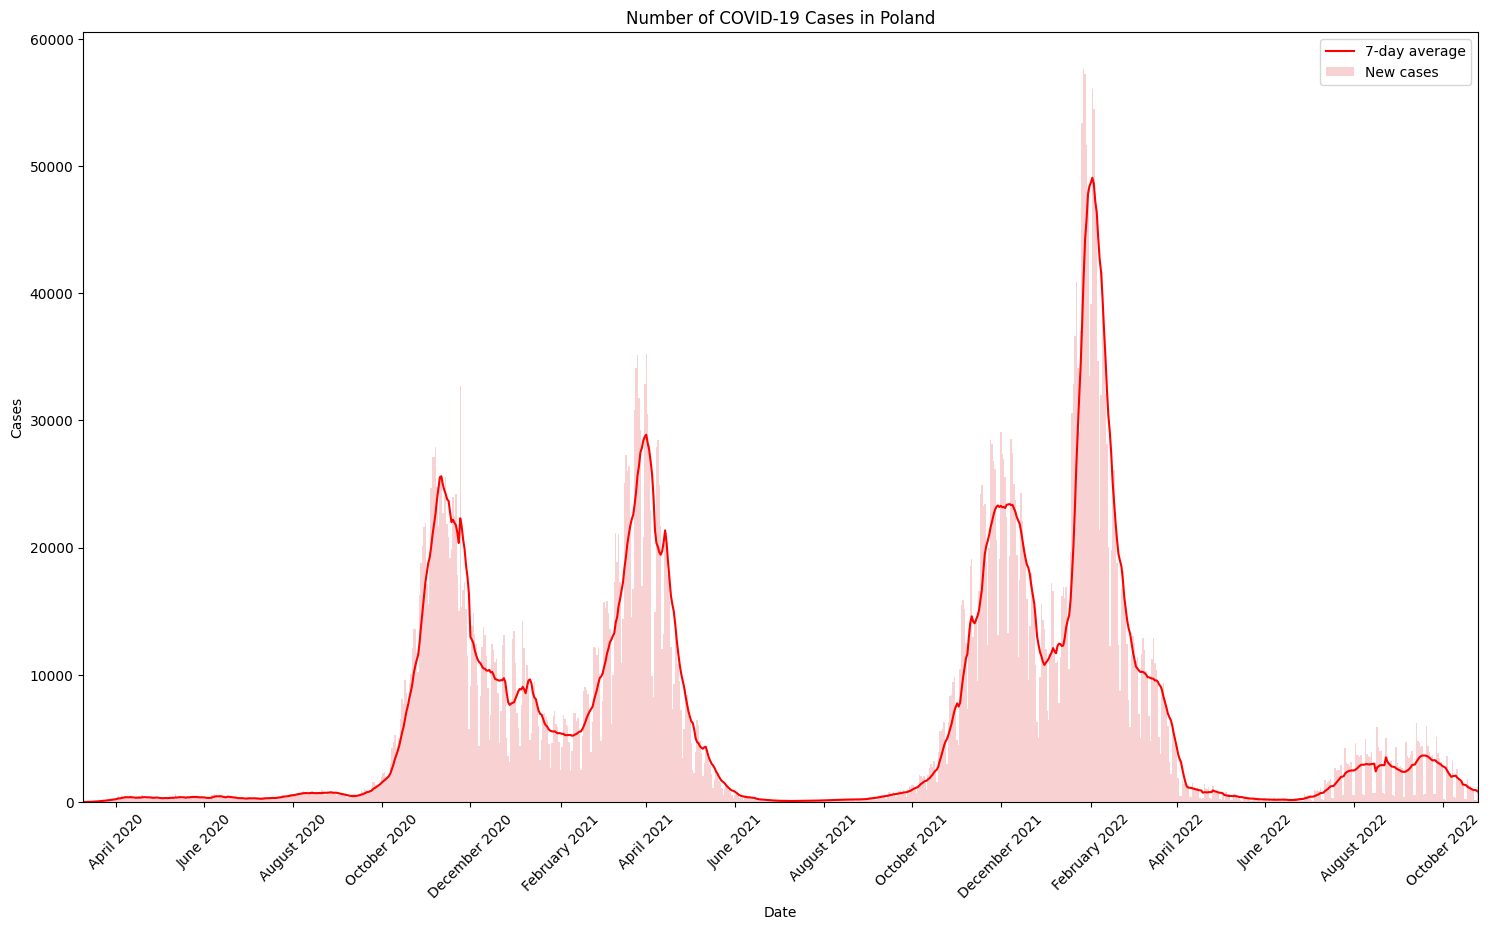

In [222]:
df_seven_window = create_window_df(df_pol)
draw_window_plot(df_seven_window)

Wykres po dokonaniu okienkowania jest znacznie bardziej czytelny niż wykres oparty na surowych danych. Warto go porównać z wykresem zaproponowanym przez Suligowskiego i Ciupę. Podobnie jak ci badacze, zdecydowaliśmy się wyznaczyć początek i koniec poszczególnych fal pandemii na podstawie punktu przegięcia krzywej rosnącej lub spadającej.



--2023-10-11 00:51:22--  https://ars.els-cdn.com/content/image/1-s2.0-S0013935122019892-gr2_lrg.jpg
Resolving ars.els-cdn.com (ars.els-cdn.com)... 172.64.155.214, 104.18.32.42, 2606:4700:4400::6812:202a, ...
Connecting to ars.els-cdn.com (ars.els-cdn.com)|172.64.155.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 939633 (918K) [image/jpeg]
Saving to: ‘1-s2.0-S0013935122019892-gr2_lrg.jpg.2’

1-s2.0-S00139351220 100%[===================>] 917.61K  --.-KB/s    in 0.06s   

2023-10-11 00:51:22 (14.9 MB/s) - ‘1-s2.0-S0013935122019892-gr2_lrg.jpg.2’ saved [939633/939633]



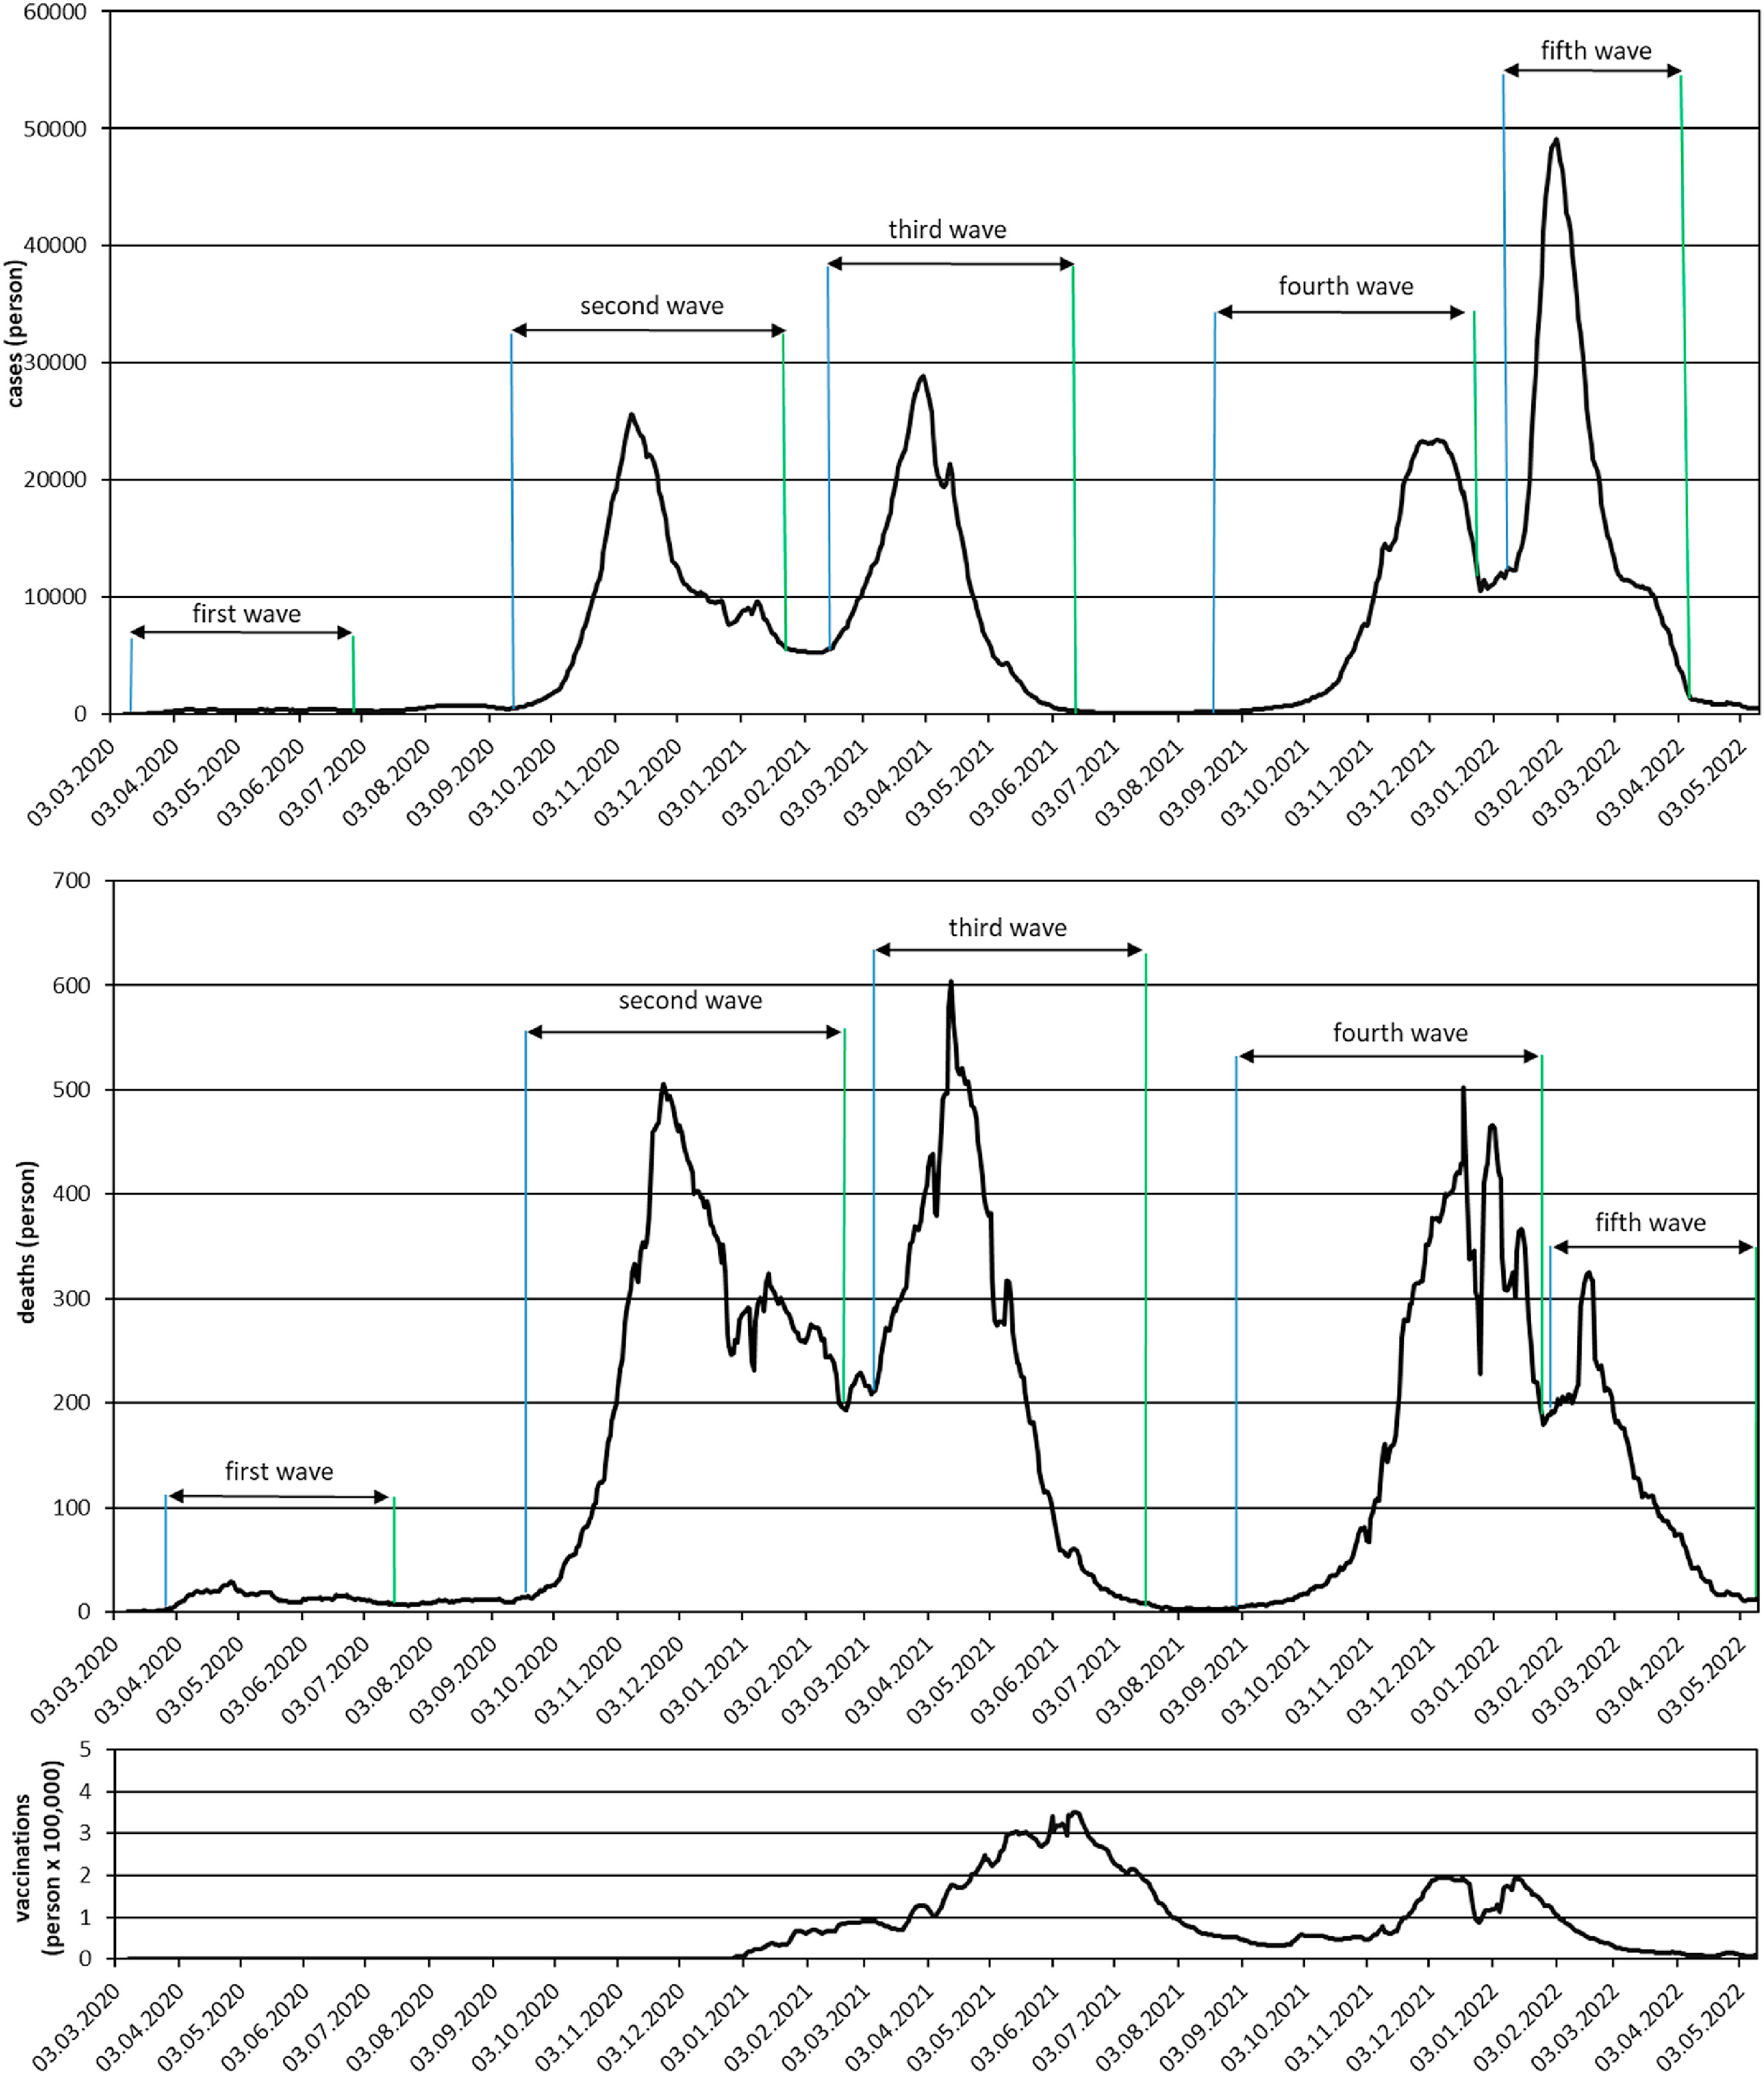

In [223]:
# Wykres Suligowskiego i Ciupy (2023)
!wget https://ars.els-cdn.com/content/image/1-s2.0-S0013935122019892-gr2_lrg.jpg
display(Image("1-s2.0-S0013935122019892-gr2_lrg.jpg", height=1200, width=1500))

Mimo że do wyznaczenia fali pandemii posłużylismy się wykresem po okienkowaniu (aby ujednolicić początek i koniec fal z tymi, które zaproponowali Suligowski i Ciupa), do analizy statystycznej (wyznaczenie min, max, średniej, mediany, dolnego i górnego kwartyla), posłużymy się rzeczywistymi, surowymi danymi (czyli liczbą zachorowań dla danego dnia w oparciu o plik udostępniony przez ECDC).

Przy wyznaczaniu początkowego i końcowego dnia fali pandemii braliśmy pod uwagę procentowy wzrost/spadek między średnią dla jednego okienka a średnią dla poprzedniego okienka (gdzie k = 7). Ustaliliśmy, że zbadamy liczbę dni w dwutygodniowym przedziale (o ile jest to możliwe) z centralnym dniem podanym przez Suligowskiego i Ciupę.

##**2.4. Wyznaczenie początku i końca fal pandemii oraz ich podstawowe statystyki**

##**2.4.1. PIERWSZA FALA PANDEMII: 12.03.2020 - 23.06.2020**

###**a) Ustalenie początkowego dnia pierwszej fali pandemii**

In [224]:
wave_candidates(df_seven_window, '2020-03-12')

,date,cases,rolling_mean,mean_change_perc
0,2020-03-10,5.0,3.142857,NaN
1,2020-03-11,9.0,4.285714,36.363636
2,2020-03-12,20.0,7.142857,66.666667
3,2020-03-13,17.0,9.000000,26.000000
4,2020-03-14,36.0,14.000000,55.555556
5,2020-03-15,21.0,16.285714,16.326531
6,2020-03-16,52.0,22.857143,40.350877
7,2020-03-17,61.0,30.857143,35.000000
8,2020-03-18,49.0,36.571429,18.518519
9,2020-03-19,68.0,43.428571,18.750000


Najwyższy procentowy przyrost między średnimi pochodzącymi z dwóch okienek odnotowano 12.03.2020 roku (66%), dlatego właśnie ten dzień nalezy uznać za początek pierwszej fali pandemii (zgadza się to zresztą z ustaleniami Suligowskiego i Ciupy).

###**b) Ustalenie końcowego dnia pierwszej fali pandemii**

In [225]:
wave_candidates(df_seven_window, '2020-06-28')

,date,cases,rolling_mean,mean_change_perc
103,2020-06-21,311.0,362.714286,-2.458701
104,2020-06-22,296.0,348.428571,-3.938558
105,2020-06-23,300.0,333.142857,-4.387044
106,2020-06-24,294.0,302.857143,-9.090909
107,2020-06-25,298.0,300.571429,-0.754717
108,2020-06-26,276.0,297.000000,-1.188213
109,2020-06-27,319.0,299.142857,0.721501
110,2020-06-28,193.0,282.285714,-5.635148
111,2020-06-29,247.0,275.285714,-2.479757
112,2020-06-30,239.0,266.571429,-3.165542


Najwyższy procentowy spadek między średnimi pochodzącymi z dwóch okienek odnotowano 24.06.2020 roku (9%), dlatego dzień wcześniejszy (23.06.2020) można uznać za ostatni dzień pierwszej fali pandemii.

###**c) Wskaźniki statystyczne dla pierwszej fali pandemii**

In [226]:
first_wave_start = '2020-03-12'
first_wave_end = '2020-06-23'
first_wave_stats = wave_stats(df_seven_window, start_date=first_wave_start, end_date=first_wave_end)

Najniższa liczba zachorowań w tej fali (min):           17.00
Najwyższa liczba zachorowań w tej fali (max):          599.00
Średnia liczba zachorowań w tej fali (mean):           312.46
Mediana liczby zachorowań w tej fali (median):         317.00
Dolny kwartyl tej fali:                                247.75
Górny kwartyl tej fali:                                395.25


###**d) Wykres pierwszej fali pandemii**

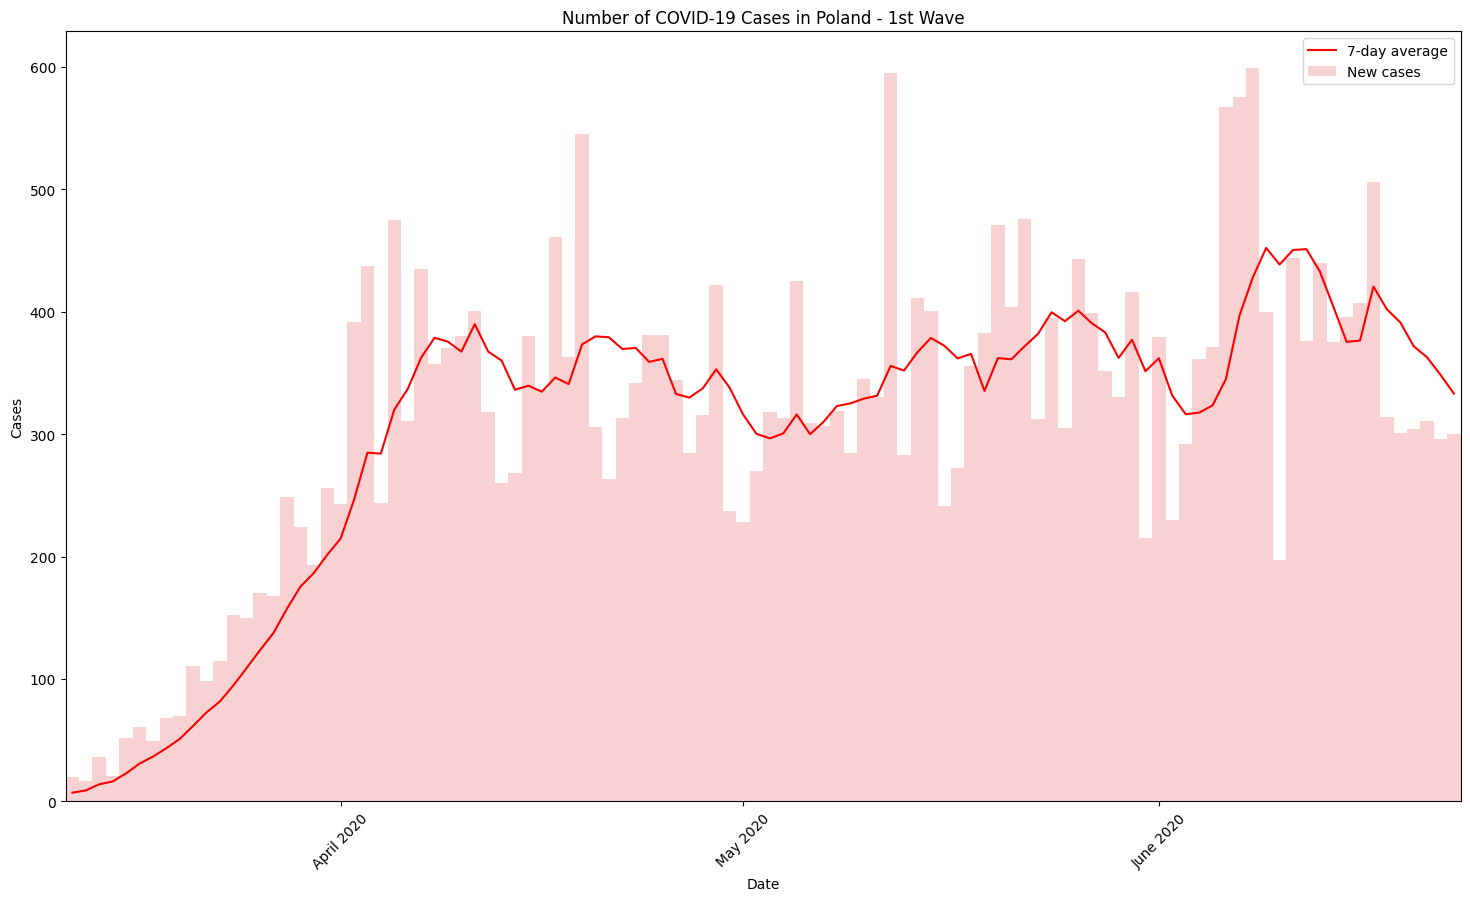

In [227]:
first_wave = create_wave_df(df_seven_window, first_wave_start, first_wave_end)
draw_window_plot(first_wave, xticks_freq='1M', plot_title='Number of COVID-19 Cases in Poland - 1st Wave')

##**2.4.2. DRUGA FALA PANDEMII: 19.09.2020 - 16.01.2021**

###**a) Ustalenie początkowego dnia drugiej fali pandemii**

In [228]:
wave_candidates(df_seven_window, '2020-09-13')

,date,cases,rolling_mean,mean_change_perc
180,2020-09-06,437.0,564.857143,-4.676953
181,2020-09-07,302.0,536.285714,-5.058169
182,2020-09-08,400.0,514.857143,-3.995738
183,2020-09-09,421.0,490.000000,-4.827969
184,2020-09-10,506.0,474.857143,-3.090379
185,2020-09-11,594.0,461.000000,-2.918171
186,2020-09-12,603.0,466.142857,1.115587
187,2020-09-13,502.0,475.428571,1.992032
188,2020-09-14,377.0,486.142857,2.253606
189,2020-09-15,605.0,515.428571,6.024096


Największy procentowy wzrost pandemii w tym okresie (licząc różnice między średnimi okienek) zanotowano 19.09.2020 (ponad 9%), dlatego ten dzień można uznać za początek drugiej fali pandemii.

###**b) Ustalenie końcowego dnia drugiej fali pandemii**

In [229]:
wave_candidates(df_seven_window, '2021-01-24')

,date,cases,rolling_mean,mean_change_perc
313,2021-01-17,5970.0,7151.428571,-5.942919
314,2021-01-18,3332.0,6932.714286,-3.058330
315,2021-01-19,4890.0,6860.714286,-1.038554
316,2021-01-20,6943.0,6548.857143,-4.545549
317,2021-01-21,7008.0,6199.000000,-5.342263
318,2021-01-22,6693.0,6018.285714,-2.915217
319,2021-01-23,6431.0,5895.285714,-2.043771
320,2021-01-24,4566.0,5694.714286,-3.402234
321,2021-01-25,2674.0,5600.714286,-1.650653
322,2021-01-26,4603.0,5559.714286,-0.732049


Najwyższy procentowy spadek między średnimi pochodzącymi z dwóch okienek odnotowano 17.01.2021 roku (prawie 6%), dlatego dzień wcześniejszy (16.01.2021) można uznać za ostatni dzień drugiej fali pandemii.

###**c) Wskaźniki statystyczne dla drugiej fali pandemii**

In [230]:
second_wave_start = '2020-09-19'
second_wave_end = '2021-01-16'
second_wave_stats = wave_stats(df_seven_window, start_date=second_wave_start, end_date=second_wave_end)

Najniższa liczba zachorowań w tej fali (min):          711.00
Najwyższa liczba zachorowań w tej fali (max):        32727.00
Średnia liczba zachorowań w tej fali (mean):         11269.03
Mediana liczby zachorowań w tej fali (median):        9831.00
Dolny kwartyl tej fali:                               4998.00
Górny kwartyl tej fali:                              15416.00


###**d) Wykres drugiej fali pandemii**

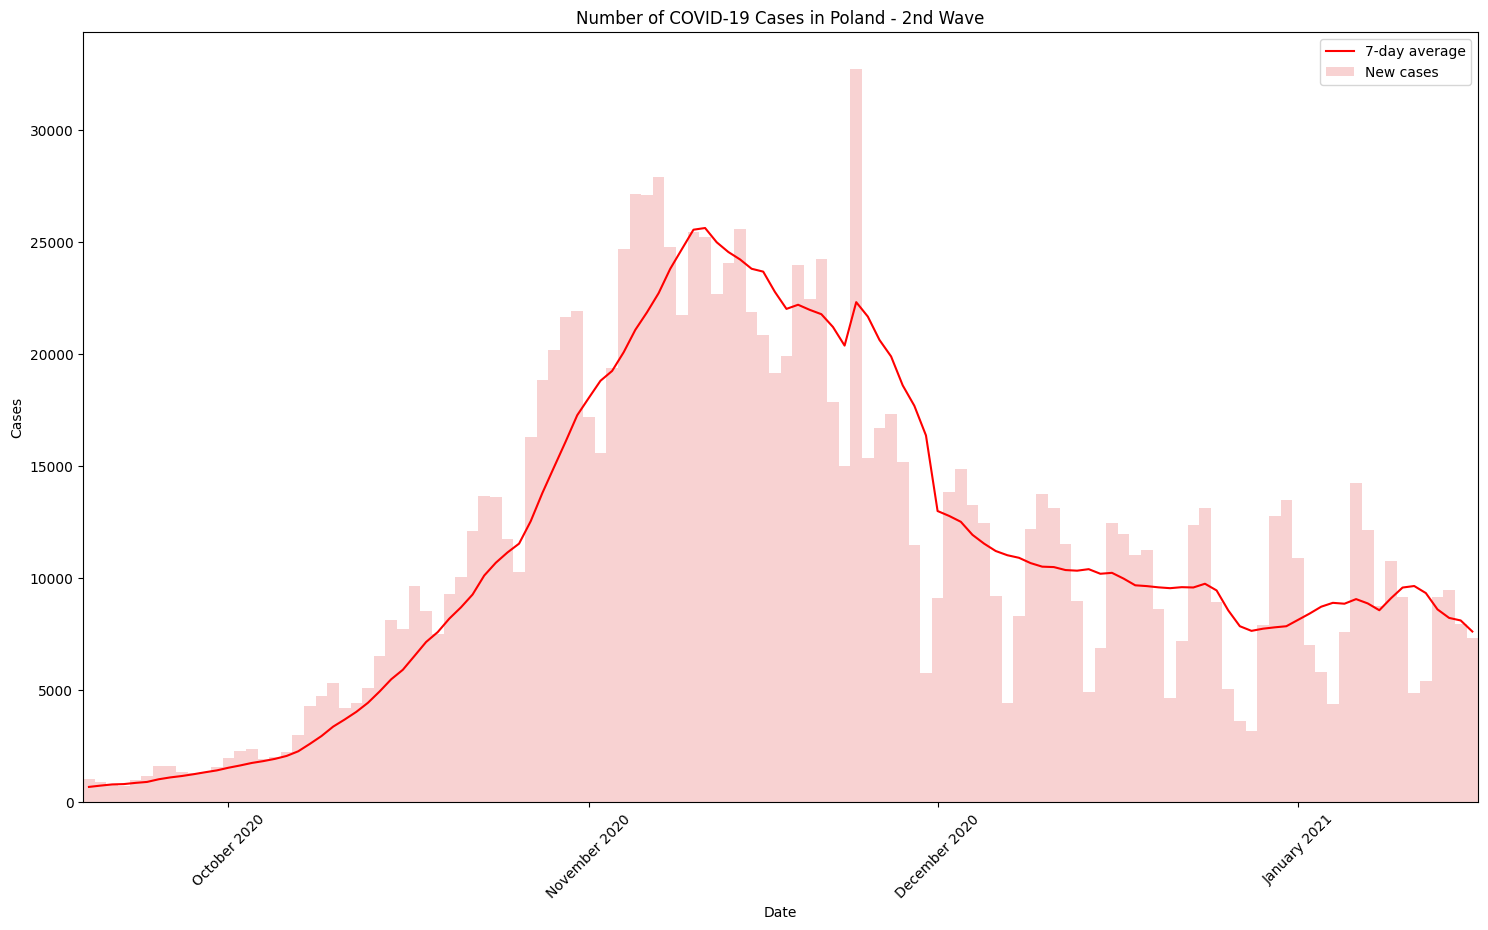

In [231]:
second_wave = create_wave_df(df_seven_window, second_wave_start, second_wave_end)
draw_window_plot(second_wave, xticks_freq='1M', plot_title='Number of COVID-19 Cases in Poland - 2nd Wave')

##**2.4.3. TRZECIA FALA PANDEMII: 19.02.2021 - 15.06.2021**

###**a) Ustalenie początkowego dnia trzeciej fali pandemii**

In [232]:
wave_candidates(df_seven_window, '2021-02-15')

,date,cases,rolling_mean,mean_change_perc
335,2021-02-08,2431.0,5256.714286,-0.197993
336,2021-02-09,3999.0,5210.000000,-0.888659
337,2021-02-10,6960.0,5232.714286,0.435975
338,2021-02-11,7013.0,5306.714286,1.414180
339,2021-02-12,6378.0,5353.142857,0.874902
340,2021-02-13,6585.0,5441.571429,1.651900
341,2021-02-14,5334.0,5528.571429,1.598803
342,2021-02-15,2542.0,5544.428571,0.286822
343,2021-02-16,5176.0,5712.571429,3.032645
344,2021-02-17,8699.0,5961.000000,4.348805


Największy procentowy wzrost pandemii w tym okresie (licząc różnice między średnimi okienek) zanotowano 19.02.2021 (ponad 5%), dlatego ten dzień można uznać za początek trzeciej fali pandemii.

###**b) Ustalenie końcowego dnia trzeciej fali pandemii**

In [233]:
wave_candidates(df_seven_window, '2021-06-13')

,date,cases,rolling_mean,mean_change_perc
453,2021-06-06,312.0,455.142857,-7.732407
454,2021-06-07,192.0,435.000000,-4.425612
455,2021-06-08,401.0,408.714286,-6.042693
456,2021-06-09,560.0,394.571429,-3.460329
457,2021-06-10,378.0,367.857143,-6.770456
458,2021-06-11,340.0,370.857143,0.815534
459,2021-06-12,236.0,345.571429,-6.818182
460,2021-06-13,226.0,333.285714,-3.555188
461,2021-06-14,139.0,325.714286,-2.271753
462,2021-06-15,211.0,298.571429,-8.333333


Najwyższy procentowy spadek między średnimi pochodzącymi z dwóch okienek odnotowano 16.06.2021 roku (ponad 15%), dlatego dzień wcześniejszy (15.06.2021) można uznać za ostatni dzień trzeciej fali pandemii.

###**c) Wskaźniki statystyczne dla trzeciej fali pandemii**

In [234]:
third_wave_start = '2021-02-19'
third_wave_end = '2021-06-15'
third_wave_stats = wave_stats(df_seven_window, start_date=third_wave_start, end_date=third_wave_end)

Najniższa liczba zachorowań w tej fali (min):          139.00
Najwyższa liczba zachorowań w tej fali (max):        35253.00
Średnia liczba zachorowań w tej fali (mean):         10798.06
Mediana liczby zachorowań w tej fali (median):        8426.00
Dolny kwartyl tej fali:                               2090.00
Górny kwartyl tej fali:                              16740.00


###**d) Wykres trzeciej fali pandemii**

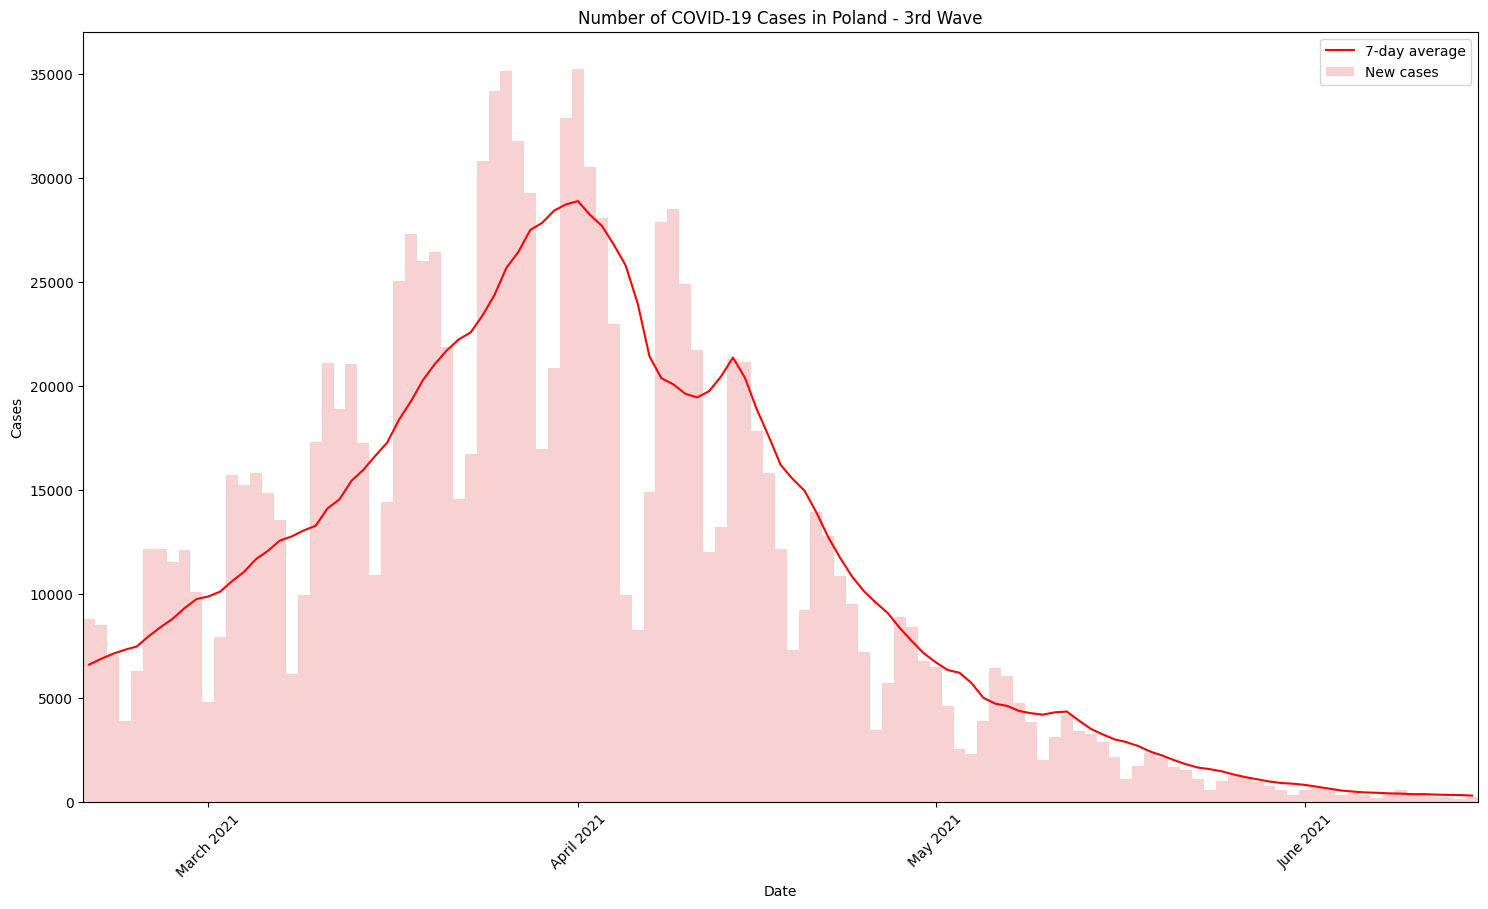

In [235]:
third_wave = create_wave_df(df_seven_window, third_wave_start, third_wave_end)
draw_window_plot(third_wave, xticks_freq='1M', plot_title='Number of COVID-19 Cases in Poland - 3rd Wave')

##**2.4.4. CZWARTA FALA PANDEMII: 16.08.2021 - 25.12.2021**

###**a) Ustalenie początkowego dnia czwartej fali pandemii**

In [236]:
wave_candidates(df_seven_window, '2021-08-22')

,date,cases,rolling_mean,mean_change_perc
523,2021-08-15,148.0,176.428571,2.150538
524,2021-08-16,128.0,185.571429,5.182186
525,2021-08-17,215.0,187.857143,1.231717
526,2021-08-18,207.0,189.428571,0.836502
527,2021-08-19,196.0,185.571429,-2.036199
528,2021-08-20,212.0,188.142857,1.385681
529,2021-08-21,222.0,189.714286,0.835232
530,2021-08-22,185.0,195.000000,2.786145
531,2021-08-23,107.0,192.000000,-1.538462
532,2021-08-24,232.0,194.428571,1.264881




Największy procentowy wzrost pandemii w tym okresie (licząc różnice między średnimi okienek) zanotowano 16.08.2021 (ponad 5%), dlatego ten dzień można uznać za początek czwartej fali pandemii.

###**b) Ustalenie końcowego dnia czwartej fali pandemii**

In [237]:
wave_candidates(df_seven_window, '2021-12-29')

,date,cases,rolling_mean,mean_change_perc
652,2021-12-22,18013.0,16988.714286,-4.993928
653,2021-12-23,17150.0,16282.142857,-4.159064
654,2021-12-24,15376.0,15617.714286,-4.080719
655,2021-12-25,10789.0,14388.714286,-7.869269
656,2021-12-26,6253.0,12999.714286,-9.653399
657,2021-12-27,5027.0,12345.000000,-5.036374
658,2021-12-28,9850.0,11779.714286,-4.579066
659,2021-12-29,15567.0,11430.285714,-2.966359
660,2021-12-30,14326.0,11026.857143,-3.529471
661,2021-12-31,13607.0,10774.142857,-2.291807


Najwyższy procentowy spadek między średnimi pochodzącymi z dwóch okienek odnotowano 26.12.2021 roku (prawie 10%), dlatego dzień wcześniejszy (25.12.2021) można uznać za ostatni dzień czwartej fali pandemii.

###**c) Wskaźniki statystyczne dla czwartej fali pandemii**

In [238]:
fourth_wave_start = '2021-08-16'
fourth_wave_end = '2021-12-25'
fourth_wave_stats = wave_stats(df_seven_window, start_date=fourth_wave_start, end_date=fourth_wave_end)

Najniższa liczba zachorowań w tej fali (min):          107.00
Najwyższa liczba zachorowań w tej fali (max):        29076.00
Średnia liczba zachorowań w tej fali (mean):          8774.64
Mediana liczby zachorowań w tej fali (median):        4223.50
Dolny kwartyl tej fali:                                617.25
Górny kwartyl tej fali:                              16134.75


###**d) Wykres czwartej fali pandemii**

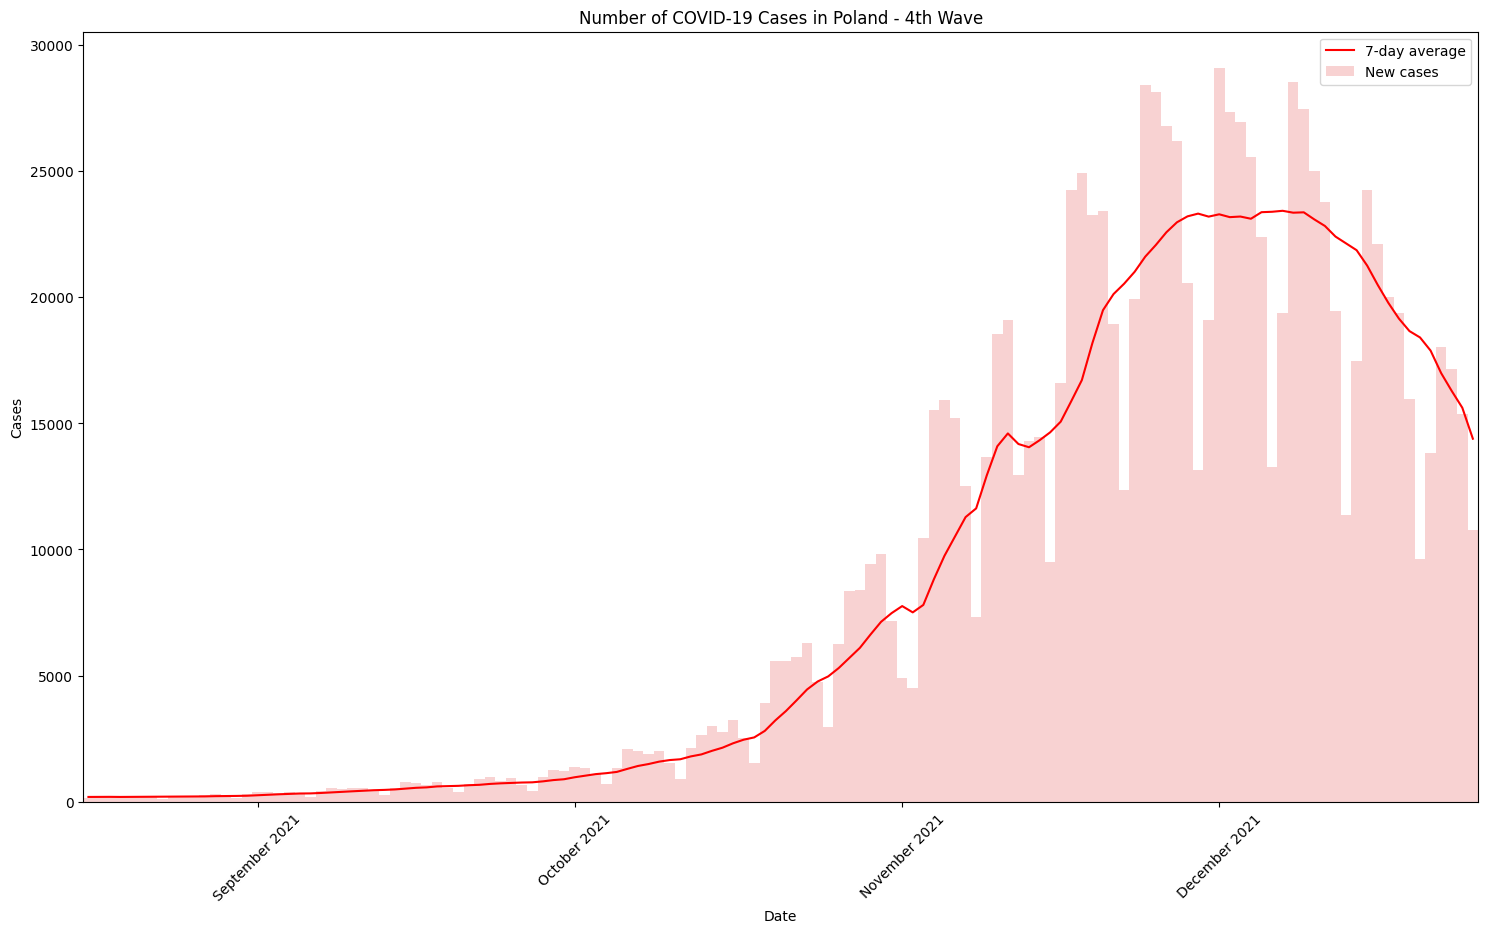

In [239]:
fourth_wave = create_wave_df(df_seven_window, fourth_wave_start, fourth_wave_end)
draw_window_plot(fourth_wave, xticks_freq='1M', plot_title='Number of COVID-19 Cases in Poland - 4th Wave')

##**2.4.5. PIĄTA FALA PANDEMII: 15.01.2022 - 7.04.2022**

###**a) Ustalenie początkowego dnia piątej fali pandemii**

In [240]:
wave_candidates(df_seven_window, '2022-01-10')

,date,cases,rolling_mean,mean_change_perc
664,2022-01-03,6423.0,11283.714286,1.799201
665,2022-01-04,11667.0,11543.285714,2.300408
666,2022-01-05,17197.0,11776.142857,2.017252
667,2022-01-06,16577.0,12097.714286,2.730703
668,2022-01-07,11901.0,11854.000000,-2.014548
669,2022-01-08,10897.0,11691.714286,-1.369038
670,2022-01-09,11107.0,12252.714286,4.798270
671,2022-01-10,7787.0,12447.571429,1.590318
672,2022-01-11,11402.0,12409.714286,-0.304133
673,2022-01-12,16173.0,12263.428571,-1.178800


Największy procentowy wzrost pandemii w tym okresie (licząc różnice między średnimi okienek) zanotowano 15.01.2022 (prawie 7%), dlatego ten dzień można uznać za początek piątej fali pandemii.

###**b) Ustalenie końcowego dnia piątej fali pandemii**

In [241]:
wave_candidates(df_seven_window, '2022-04-08')

,date,cases,rolling_mean,mean_change_perc
752,2022-04-01,3668.0,4354.857143,-10.839427
753,2022-04-02,1913.0,3775.428571,-13.305341
754,2022-04-03,499.0,3393.714286,-10.110489
755,2022-04-04,461.0,3150.857143,-7.156087
756,2022-04-05,1705.0,2547.428571,-19.151251
757,2022-04-06,1408.0,2020.571429,-20.681920
758,2022-04-07,1346.0,1571.428571,-22.228507
759,2022-04-08,1197.0,1218.428571,-22.463636
760,2022-04-09,1312.0,1132.571429,-7.046547
761,2022-04-10,400.0,1118.428571,-1.248739


Najwyższy procentowy spadek między średnimi pochodzącymi z dwóch okienek odnotowano 8.04.2022 roku (ponad 22%), dlatego dzień wcześniejszy (7.04.2022) można uznać za ostatni dzień piątej fali pandemii.

###**c) Wskaźniki statystyczne dla piątej fali pandemii**

In [242]:
fifth_wave_start = '2022-01-15'
fifth_wave_end = '2022-04-07'
fifth_wave_stats = wave_stats(df_seven_window, start_date=fifth_wave_start, end_date=fifth_wave_end)

Najniższa liczba zachorowań w tej fali (min):          461.00
Najwyższa liczba zachorowań w tej fali (max):        57659.00
Średnia liczba zachorowań w tej fali (mean):         19372.60
Mediana liczby zachorowań w tej fali (median):       12518.00
Dolny kwartyl tej fali:                               7679.00
Górny kwartyl tej fali:                              31279.00


###**d) Wykres piątej fali pandemii**

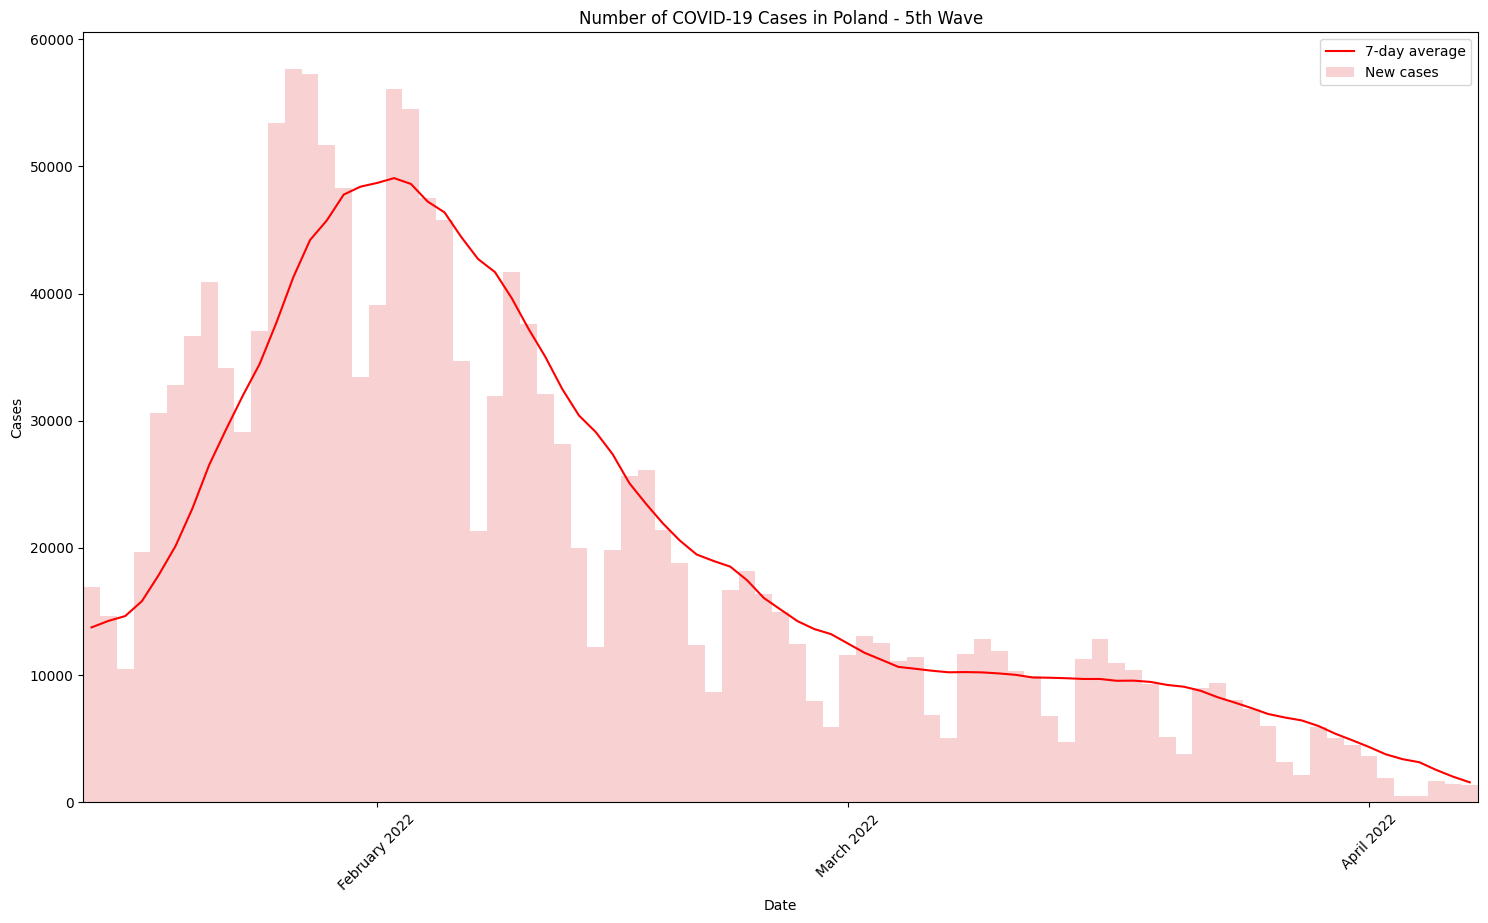

In [243]:
fifth_wave = create_wave_df(df_seven_window, fifth_wave_start, fifth_wave_end)
draw_window_plot(fifth_wave, xticks_freq='1M', plot_title='Number of COVID-19 Cases in Poland - 5th Wave')

##**2.4.6. SZÓSTA FALA PANDEMII: 24.06.2022 - 24.10.2022**


###**a) Ustalenie początkowego dnia szóstej fali pandemii**

In [244]:
wave_candidates(df_seven_window, '2022-06-21')

,date,cases,rolling_mean,mean_change_perc
826,2022-06-14,279.0,180.428571,-1.173709
827,2022-06-15,207.0,184.428571,2.216944
828,2022-06-16,209.0,178.714286,-3.098373
829,2022-06-17,43.0,152.285714,-14.788169
830,2022-06-18,228.0,150.714286,-1.031895
831,2022-06-19,57.0,151.714286,0.663507
832,2022-06-20,42.0,152.142857,0.282486
833,2022-06-21,324.0,158.571429,4.225352
834,2022-06-22,285.0,169.714286,7.027027
835,2022-06-23,268.0,178.142857,4.966330


Największy procentowy wzrost pandemii w tym okresie (licząc różnice między średnimi okienek) zanotowano 24.06.2022 (ponad 21 %), dlatego ten dzień można uznać za początek szóstej (ostatniej) fali pandemii.

###**b) Ustalenie końcowego dnia szóstej fali pandemii**

In [245]:
wave_candidates(df_seven_window, '2022-10-25')

,date,cases,rolling_mean,mean_change_perc
952,2022-10-18,1773.0,1213.571429,-9.008141
953,2022-10-19,1299.0,1130.857143,-6.815774
954,2022-10-20,1223.0,1082.714286,-4.257201
955,2022-10-21,937.0,1007.857143,-6.913841
956,2022-10-22,901.0,951.571429,-5.584692
957,2022-10-23,166.0,936.285714,-1.606365
958,2022-10-24,153.0,921.714286,-1.556301
959,2022-10-25,1181.0,837.142857,-9.175449


Najwyższy procentowy spadek między średnimi pochodzącymi z dwóch okienek odnotowano 25.10.2022 roku (ponad 9%), dlatego dzień wcześniejszy (24.10.2022) można uznać za ostatni dzień ostatniej fali pandemii.

###**c) Wskaźniki statystyczne dla szóstej fali pandemii**

In [246]:
sixth_wave_start = '2022-06-24'
sixth_wave_end ='2022-10-24'
sixth_wave_stats = wave_stats(df_seven_window, start_date=sixth_wave_start, end_date=sixth_wave_end)

Najniższa liczba zachorowań w tej fali (min):           84.00
Najwyższa liczba zachorowań w tej fali (max):         6178.00
Średnia liczba zachorowań w tej fali (mean):          2155.86
Mediana liczby zachorowań w tej fali (median):        1833.00
Dolny kwartyl tej fali:                                573.00
Górny kwartyl tej fali:                               3600.50


###**d) Wykres szóstej fali pandemii**

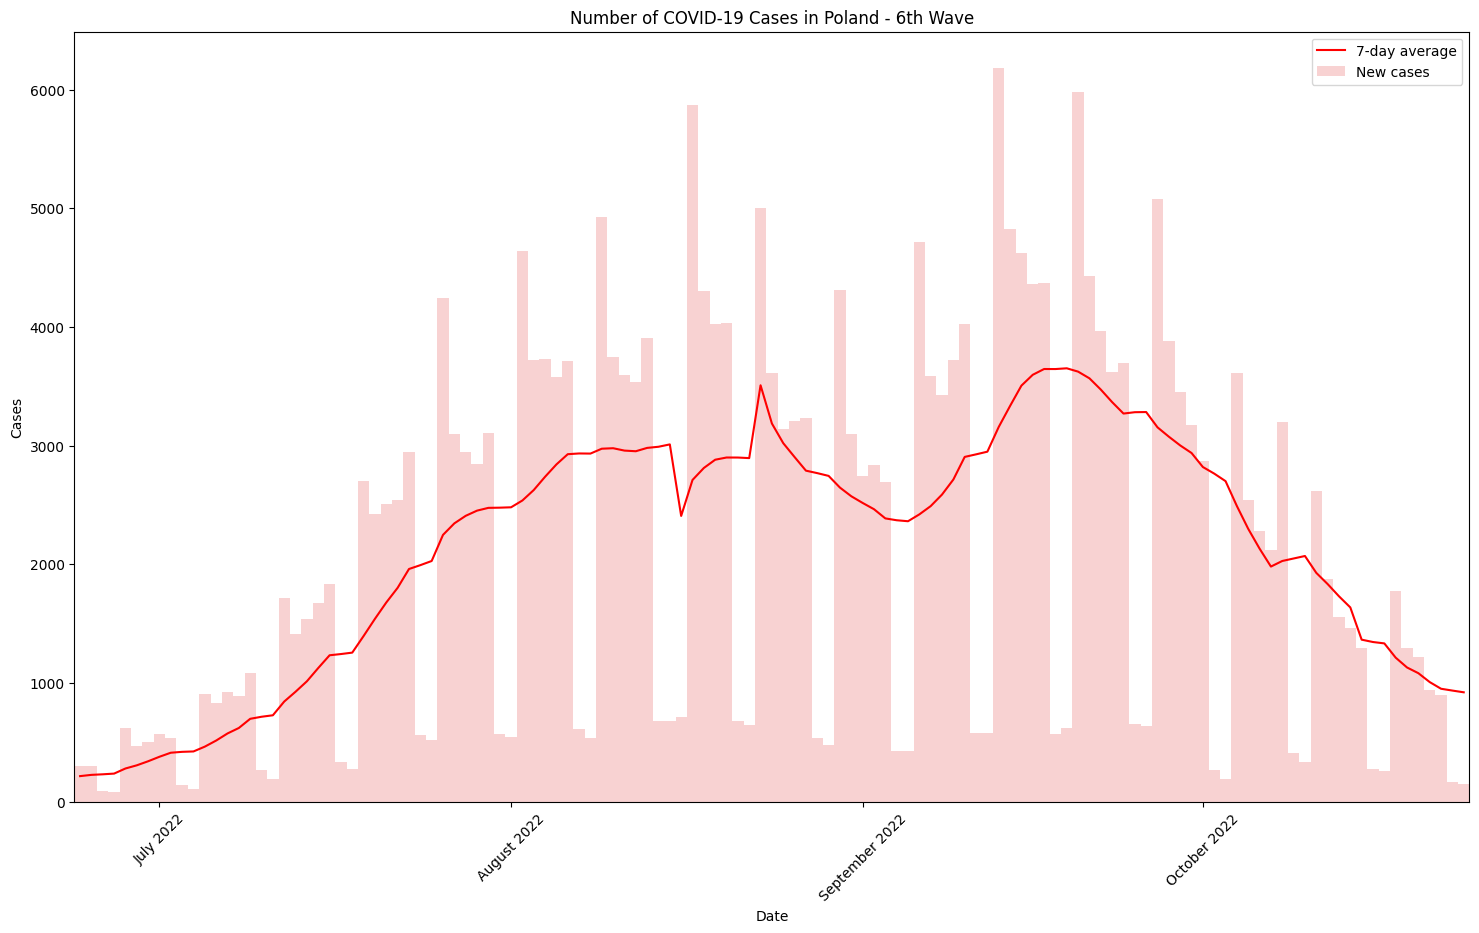

In [247]:
sixth_wave = create_wave_df(df_seven_window, sixth_wave_start, sixth_wave_end)
draw_window_plot(sixth_wave, xticks_freq='1M', plot_title='Number of COVID-19 Cases in Poland - 6th Wave')

In [248]:
sixth_wave_stats = wave_stats(df_seven_window, start_date=sixth_wave_start, end_date=sixth_wave_end)

Najniższa liczba zachorowań w tej fali (min):           84.00
Najwyższa liczba zachorowań w tej fali (max):         6178.00
Średnia liczba zachorowań w tej fali (mean):          2155.86
Mediana liczby zachorowań w tej fali (median):        1833.00
Dolny kwartyl tej fali:                                573.00
Górny kwartyl tej fali:                               3600.50


##**2.4.7. Podsumowanie statystyk wszystkich fal pandemii**

In [249]:
waves_stats_list = [list(first_wave_stats),
                    list(second_wave_stats),
                    list(third_wave_stats),
                    list(fourth_wave_stats),
                    list(fifth_wave_stats),
                    list(sixth_wave_stats)]

waves_summary_df = pd.DataFrame(waves_stats_list, columns=['min', 'max', 'mean', 'median', 'lower_quartile', 'upper_quartile'])
index = pd.Index(['first_wave', 'second_wave', 'third_wave', 'forth_wave', 'fifth_wave', 'sixth_wave'])
waves_summary_df = waves_summary_df.set_index(index)

In [250]:
waves_summary_df

,min,max,mean,median,lower_quartile,upper_quartile
first_wave,17.0,599.0,312.46,317.0,247.75,395.25
second_wave,711.0,32727.0,11269.03,9831.0,4998.00,15416.00
third_wave,139.0,35253.0,10798.06,8426.0,2090.00,16740.00
forth_wave,107.0,29076.0,8774.64,4223.5,617.25,16134.75
fifth_wave,461.0,57659.0,19372.60,12518.0,7679.00,31279.00
sixth_wave,84.0,6178.0,2155.86,1833.0,573.00,3600.50


##**3. PRZYGOTOWNANIE DANYCH DO ANALIZY I TRENOWANIE KLASYFIKATORÓW**

##**3.1. Funkcje pomocnicze**

Na potrzeby analizy stworzono funkcje pomocnicze:


*   `split_data` - funkcja dzieląca dane na dane treningowe i testowe; przyjmuje dataframe jako parametr
*   `scale_data` - funkcja, która skaluje dane, aby ułatwić modelom proces uczenia
*   `rmse` - funkcja wyliczająca średni błąd kwadratowy RMSE
*   `mae` - funkcja wyliczająca średni błąd bezwzględny MAE
*   `mape` - funkcja wyliczająca średni bezwzględny błąd procentowy MAPE

In [251]:
# Nazwy kolumn zawierających atrybuty objaśniające i atrybut docelowy
features_columns =  ['rolling_mean', 'rolling_median', 'rolling_min', 'rolling_max', 'rolling_difference']
target_column = ['next_day_cases']

# Funkcja dzieląca dane na dane treningowe i dane testowe
def split_data(df):
    # określenie które kolumny zawierają atrybuty objaśniające i atrybut docelowy
    X = df[features_columns].values
    y = df[target_column].values
    # dzielenie danych w stosunku trening:test = 0.8:0.2
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X, y, X_train, X_test, y_train, y_test

# Słowniki do przechowywania estymatorów skalujących dane dla poszczególnych długości okienek
# Skalowanie danych, osobne dla atrybutów objaśniających, osobne dla atrybutu docelowego
scaleX_dict = {}
scaley_dict = {}

# Funkcja skalująca dane
def scale_data(X, y, X_train, X_test, y_train, y_test, window_interval):
    # skala dla atrybutów objaśniających i atrybutu objaśnianego
    scale_X = MinMaxScaler(feature_range=(0, 1))
    scale_y = MinMaxScaler(feature_range=(0, 1))
    # dopasowanie skali do danych
    X_train_sc = scale_X.fit_transform(X_train)
    X_test_sc = scale_X.transform(X_test)
    y_train_sc = scale_y.fit_transform(y_train)
    y_test_sc = scale_y.transform(y_test)
    # zapisanie skal w słownikach
    scaleX_dict[window_interval] = scale_X
    scaley_dict[window_interval] = scale_y
    return X_train_sc, y_train_sc, X_test_sc, y_test_sc

# Funkcje służące do obliczenia miar dokładności predykcji
# średni błąd kwadratowy RMSE
def rmse(y_real, y_pred):
    return sqrt(mean_squared_error(y_real, y_pred))

# średni błąd bezwzględny MAE
def mae(y_real, y_pred):
    return mean_absolute_error(y_real, y_pred)

# średni bezwzględny błąd procentowy MAPE
def mape(y_real, y_pred):
    return mean_absolute_percentage_error(y_real, y_pred)

# Funkcja zwracająca wielkość okienka dla modelu o najmniejszym RMSE
def min_rmse_interval(models_metrics):
    min_rmse_row = models_metrics[models_metrics['RMSE'] == models_metrics['RMSE'].min()]
    window_interval = min_rmse_row['window_interval'].values[0]
    return window_interval

# Funkcja podsumowująca najważniejsze metryki dla najlepszego modelu
def min_rmse_stats(models_metrics, model_name):
    min_rmse_row = models_metrics[models_metrics['RMSE'] == models_metrics['RMSE'].min()]
    # wybranie odpowiednich wartości z tabeli metryk
    window_interval = min_rmse_row['window_interval'].values[0]
    rmse = min_rmse_row['RMSE'].values[0].round().astype(int)
    R2 = min_rmse_row['R2'].values[0].round(2)
    # wypisanie najważniejszych informacji
    print(f"""Najlepszy wynik RMSE dla {model_name}:\n
{'długość okna czasowego [dni]:':<35} {window_interval:>6}
{'średni błąd kwadratowy RMSE:':<35} {rmse:>6}
{'współczynnik determinacji R2:':<35} {R2:>6.2f}""")

# Funkcja tworząca wykres przewidywanych przypadków dla wybranego modelu
def plot_predictions(df, window_interval, pred_models):
    # wybór odpowiedniego skalowania i modelu
    scale_X = scaleX_dict[window_interval]
    scale_y = scaley_dict[window_interval]
    model = pred_models[window_interval][1]
    # przygotowanie danych i predykcja
    window_df = create_window_df(df, window_interval)
    X = window_df[features_columns].values
    X_sc = scale_X.transform(X)
    y_pred_sc = model.predict(X_sc)
    y_pred = scale_y.inverse_transform(y_pred_sc.reshape(-1, 1))
    # usunięcie pierwszych wierszy, aby zgadzały się daty
    df = df.iloc[window_interval-1:, :]
    df.reset_index(drop=True, inplace=True)
    # wybór odpowiednich kolumn z danymi do rysowania wykresu
    date_window = window_df['date']
    window_df['predicted_cases'] = y_pred.reshape(-1)
    # określenie z których dni pochodzą pierwsze i ostatnie dane
    latest_date = df['dateRep'].max()
    earliest_date = df['dateRep'].min()
    # tworzenie znaczników dla osi X
    dates_xticks = pd.date_range(earliest_date, latest_date , freq='2M') + pd.offsets.MonthBegin(1)
    dates_xticks = dates_xticks.tolist()
    dates_xticks = list(map(lambda x: x.to_pydatetime().date(), dates_xticks))
    dates_xindex = df_pol.index[df_pol['dateRep'].apply(lambda d: d in dates_xticks)]
    dates_xlabels = list(map(lambda x: x.strftime('%B %Y'), dates_xticks))
    # nazwa wykresu
    plot_title = ''
    if 'regr' in pred_models[2][0]:
        plot_title = 'Number of COVID-19 Cases in Poland - Multiple Regression'
    elif 'tree' in pred_models[2][0]:
        plot_title = 'Number of COVID-19 Cases in Poland - Regression Tree'
    elif 'net' in pred_models[2][0]:
        plot_title = 'Number of COVID-19 Cases in Poland - LSTM Neural Network'
    # rysowanie wykresów
    fig, ax = plt.subplots(figsize=(18, 10))
    sns.barplot(x=df.index, y='cases', data=df, color='red', width=1, alpha=0.2, label='actual new cases')
    sns.lineplot(x=window_df.index, y='predicted_cases', data=window_df, color='red', label=f'predicted cases for {window_interval}-day window')
    ax.set(title=plot_title, xlabel='Date', ylabel='Cases')
    ax.set_xticks(dates_xindex)
    ax.set_xticklabels(dates_xlabels, rotation=45)
    ax.set_ylim(0, 60000)
    ax.legend(loc=0)
    plt.show()

##**3.2. Funkcje tworzące modele**

Jednym z celów jest określenie optymalnej długości okna czasowego na podstawie miar jakości modeli. Dla każdej wartości okna czasowego tworzone będą osobne modele i w celu ułatwienia całego procesu, stworzono funkcje, które będą tworzyć te modele.

###**Multiple Regression**

In [252]:
# Funkcja tworząca model regresji wielorakiej
def lin_regr(X_train_sc, y_train_sc, X_test_sc, y_test, window_interval):
    # tworzenie modelu
    regr_model = linear_model.LinearRegression()
    regr_model.fit(X_train_sc, y_train_sc)
    # predykcja atrybutu docelowego
    scale_y = scaley_dict[window_interval]
    y_pred_sc = regr_model.predict(X_test_sc)
    y_pred = scale_y.inverse_transform(y_pred_sc.reshape(-1, 1))
    # miary jakości modelu
    rmse_regr = rmse(y_test, y_pred)
    mse_regr = rmse_regr**2
    mae_regr = mae(y_test, y_pred)
    mape_regr = mape(y_test, y_pred)
    r2_regr = r2_score(y_test, y_pred)
    return regr_model, rmse_regr, mse_regr, mae_regr, mape_regr, r2_regr

###**Regression Tree**

In [253]:
# Funkcja tworząca model drzewa regresyjnego
def decision_tree(X_train_sc, y_train_sc, X_test_sc, y_test, window_interval):
    # tablice, które będą przechowywać miary jakości modelu
    rmse_values = []
    mae_values = []
    mape_values = []
    r2_scores = []
    parameters = []
    tree_models = []
    # sprawdzenie, które wartości parametrów 'min_samples_leaf' i 'min_samples_split' dadzą najlepsze rezultaty
    for l in range(1, 30):
        for s in range(2, 30):
            # tworzenie modelu
            model = DecisionTreeRegressor(criterion='squared_error', min_samples_leaf=l, min_samples_split=s, random_state=42)
            model.fit(X_train_sc, y_train_sc)
            # predykcja atrybutu docelowego
            scale_y = scaley_dict[window_interval]
            y_pred_sc = model.predict(X_test_sc)
            y_pred = scale_y.inverse_transform(y_pred_sc.reshape(-1, 1))
            # dodawanie do tablic kolejnych miar jakości modelu oraz parametrów 'min_samples_leaf' i 'min_samples_split'
            rmse_values.append(rmse(y_test, y_pred))
            mae_values.append(mae(y_test, y_pred))
            mape_values.append(mape(y_test, y_pred))
            r2_scores.append(r2_score(y_test, y_pred))
            parameters.append((l, s))
            tree_models.append(model)
    # najlepsza miara jakości modelu
    rmse_tree = np.min(rmse_values)
    mse_tree = rmse_tree**2
    index = rmse_values.index(rmse_tree)
    r2_tree = r2_scores[index]
    mae_tree = mae_values[index]
    mape_tree = mape_values[index]
    best_params = parameters[index]
    tree_model = tree_models[index]
    best_min_samples_leaf = best_params[0]
    best_min_samples_split = best_params[1]
    return tree_model, rmse_tree, mse_tree, mae_tree, mape_tree, r2_tree, best_min_samples_leaf, best_min_samples_split

###**Neural Network**

In [254]:
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')
# Funkcja tworząca model sieci neuronowej
def neural_net(X_train_sc, y_train_sc, X_test_sc, y_test, window_interval):
    features_shape = X_train_sc.shape[1]
    # tworzenie sekwencyjnego modelu sieci neuronowej LSTM
    neural_model = Sequential()
    neural_model.add(Input(shape=(features_shape, 1)))
    neural_model.add(LSTM(48, return_sequences=True))
    neural_model.add(Dropout(0.4))
    neural_model.add(LSTM(48, return_sequences=True))
    neural_model.add(Dropout(0.2))
    neural_model.add(LSTM(48))
    neural_model.add(Dropout(0.2))
    neural_model.add(Dense(1, activation='sigmoid'))

    neural_model.compile(loss = 'mean_squared_error',
                         optimizer = 'adam',
                         metrics = ['mean_squared_error'])
    # uczenie modelu
    hist = neural_model.fit(X_train_sc, y_train_sc, batch_size=64, epochs=100, validation_split=0.25, shuffle=True, verbose=0, callbacks=[earlystopper])
    # predykcja atrybutu docelowego
    scale_y = scaley_dict[window_interval]
    y_pred_sc = neural_model.predict(X_test_sc)
    y_pred = scale_y.inverse_transform(y_pred_sc.reshape(-1, 1))
    # miary jakości modelu
    rmse_net = rmse(y_test, y_pred)
    mse_net = rmse_regr**2
    mae_net = mae(y_test, y_pred)
    mape_net = mape(y_test, y_pred)
    r2_net = r2_score(y_test, y_pred)
    return neural_model, rmse_net, mse_net, mae_net, mape_net, r2_net

##**3.3. Miary jakości modeli dla poszczególnych długości okna czasowego**
Dla każdej wartości długości okna czasowego (zakres od 2 do 14 dni) wywoływane są funkcje tworzące modele. Dla każdego modelu wyliczane są jego miary jakości. Na ich podstawie możliwe będzie wytypowanie najlepszych modeli służących do predykcji zakażeń.

In [255]:
# słowniki do przechowywania modeli
regr_models = {}
tree_models = {}
net_models = {}
# tablice do przechowywania miar jakości modeli
regr_eval = []
tree_eval = []
net_eval = []

# sprawdzanie kolejnych długości okien czasowych pętlą for
for window_interval in range(2, 15):
    # tworzenie dataframe zawierającego potrzebne atrybuty dla danego okna czasowego
    window_df = create_window_df(df_pol, window_interval)
    window_df.dropna(axis=0, inplace=True)
    # dzielenie danych i ich skalowanie
    X, y, X_train, X_test, y_train, y_test = split_data(window_df)
    X_train_sc, y_train_sc, X_test_sc, y_test_sc = scale_data(X, y, X_train, X_test, y_train, y_test, window_interval)
    # tworzenie modeli i zapisanie ich miar jakości w zmiennych
    regr_model, rmse_regr, mse_regr, mae_regr, mape_regr, r2_regr = lin_regr(X_train_sc, y_train_sc, X_test_sc, y_test, window_interval)
    tree_model, rmse_tree, mse_tree, mae_tree, mape_tree, r2_tree, min_leaf, min_split = decision_tree(X_train_sc, y_train_sc, X_test_sc, y_test, window_interval)
    net_model, rmse_net, mse_net, mae_net, mape_net, r2_net = neural_net(X_train_sc, y_train_sc, X_test_sc, y_test, window_interval)
    # dodanie modelu do odpowiednich list
    regr_models[window_interval] = (f'regr_model_{window_interval}', regr_model)
    tree_models[window_interval] = (f'tree_model_{window_interval}', tree_model)
    net_models[window_interval] = (f'net_model_{window_interval}', net_model)
    # wstawienie miar jakości modeli do tabel
    regr_eval.append([window_interval, rmse_regr, mse_regr, mae_regr, mape_regr, r2_regr])
    tree_eval.append([window_interval, rmse_tree, mse_tree, mae_tree, mape_tree, r2_tree, min_leaf, min_split])
    net_eval.append([window_interval, rmse_net, mse_net, mae_net, mape_net, r2_net])

# dataframe zawierający miary jakości dla każdego rodzaju modeli
df_regr = pd.DataFrame(regr_eval, columns=['window_interval', 'RMSE', 'MSE', 'MAE', 'MAPE', 'R2'])
df_tree = pd.DataFrame(tree_eval, columns=['window_interval', 'RMSE', 'MSE', 'MAE', 'MAPE', 'R2', 'min_samples_leaf', 'min_samples_split'])
df_net = pd.DataFrame(net_eval, columns=['window_interval', 'RMSE', 'MSE', 'MAE', 'MAPE', 'R2'])

# zapisywanie modeli
with open('regr_models.pckl', 'wb') as f:
    for model in regr_models:
        pickle.dump(model, f)
with open('tree_models.pckl', 'wb') as f:
    for model in tree_models:
        pickle.dump(model, f)
with open('net_models.pckl', 'wb') as f:
    for model in net_models:
        pickle.dump(model, f)

7/7 [==============================] - 1s 6ms/step
Epoch 89: early stopping
7/7 [==============================] - 1s 5ms/step
Epoch 100: early stopping
6/6 [==============================] - 1s 5ms/step
Epoch 95: early stopping
6/6 [==============================] - 1s 5ms/step
Epoch 81: early stopping
6/6 [==============================] - 1s 4ms/step
Epoch 94: early stopping
6/6 [==============================] - 1s 5ms/step
Epoch 36: early stopping
6/6 [==============================] - 2s 6ms/step


###a) Multiple Regression

In [256]:
# miary jakości modeli regresji wielorakiej
df_regr

,window_interval,RMSE,MSE,MAE,MAPE,R2
0,2,3428.037211,1.175144e+07,1834.642262,0.949122,0.877791
1,3,3414.324086,1.165761e+07,1755.294089,0.617323,0.883074
2,4,3526.971982,1.243953e+07,1828.577300,0.593102,0.875506
3,5,3237.627768,1.048223e+07,1764.895094,0.625316,0.875710
4,6,3538.479900,1.252084e+07,1920.241571,0.559936,0.846280
5,7,3620.669473,1.310925e+07,1914.580600,0.618941,0.830650
6,8,3689.425318,1.361186e+07,1821.443794,0.514028,0.822736
7,9,3973.201138,1.578633e+07,2064.841116,0.652132,0.813712
8,10,4211.208774,1.773428e+07,2313.319010,0.651913,0.833109
9,11,3759.016052,1.413020e+07,2228.013056,0.761559,0.864505


In [257]:
# miary jakości modelu regresji wielorakiej o najniższej wartość RMSE
min_rmse_stats(df_regr, 'regresji wielorakiej')

Najlepszy wynik RMSE dla regresji wielorakiej:

długość okna czasowego [dni]:            5
średni błąd kwadratowy RMSE:          3238
współczynnik determinacji R2:         0.88


###b) Regression Tree

In [258]:
# miary jakości modeli drzewa regresyjnego
df_tree

,window_interval,RMSE,MSE,MAE,MAPE,R2,min_samples_leaf,min_samples_split
0,2,3401.300457,1.156884e+07,1864.578663,0.666545,0.879690,21,2
1,3,3377.401073,1.140684e+07,1760.544007,0.522941,0.885590,10,2
2,4,3422.740086,1.171515e+07,1810.707733,0.509874,0.882755,8,2
3,5,2962.683733,8.777495e+06,1560.390072,0.428957,0.895923,3,13
4,6,3481.999929,1.212432e+07,1962.130372,0.572020,0.851148,4,11
5,7,3284.070707,1.078512e+07,1793.210542,0.536940,0.860674,17,2
6,8,3333.392603,1.111151e+07,1831.401042,0.634006,0.855297,1,2
7,9,3877.877248,1.503793e+07,2041.140068,0.602214,0.822544,22,2
8,10,4557.766648,2.077324e+07,2408.058550,0.574036,0.804511,11,2
9,11,3830.337689,1.467149e+07,2047.159168,0.628265,0.859315,9,22


In [259]:
# miary jakości modelu drzewa regresyjnego o najniższej wartość RMSE
min_rmse_stats(df_tree, 'drzewa regresyjnego')

Najlepszy wynik RMSE dla drzewa regresyjnego:

długość okna czasowego [dni]:            5
średni błąd kwadratowy RMSE:          2963
współczynnik determinacji R2:         0.90


###c) Neural Network

In [260]:
# miary jakości modeli sieci neuronowej
df_net

,window_interval,RMSE,MSE,MAE,MAPE,R2
0,2,4121.731836,1.175144e+07,2395.741690,2.231420,0.823326
1,3,3710.036174,1.165761e+07,2185.252727,1.691534,0.861944
2,4,3855.483283,1.243953e+07,2205.376034,1.489310,0.851234
3,5,3824.860366,1.048223e+07,2267.672348,1.418384,0.826534
4,6,3770.710661,1.252084e+07,2179.992970,1.117374,0.825440
5,7,3840.607839,1.310925e+07,2053.525867,1.058056,0.809451
6,8,3850.116789,1.361186e+07,1945.374872,1.274023,0.806958
7,9,4004.043704,1.578633e+07,2236.774660,1.294748,0.810809
8,10,4314.763184,1.773428e+07,2464.670116,1.111045,0.824801
9,11,3888.869773,1.413020e+07,2399.618259,1.891190,0.854982


In [261]:
# miary jakości modelu sieci neuronowej LSTM o najniższej wartość RMSE
min_rmse_stats(df_net, 'sieci neuronowej')

Najlepszy wynik RMSE dla sieci neuronowej:

długość okna czasowego [dni]:            3
średni błąd kwadratowy RMSE:          3710
współczynnik determinacji R2:         0.86


##**3.4. Wykresy i analiza wyników**
Spośród wszystkich modeli najlepszą miarę osiągnęła regresja wieloraka dla okna czasowego o długości 5 dni.

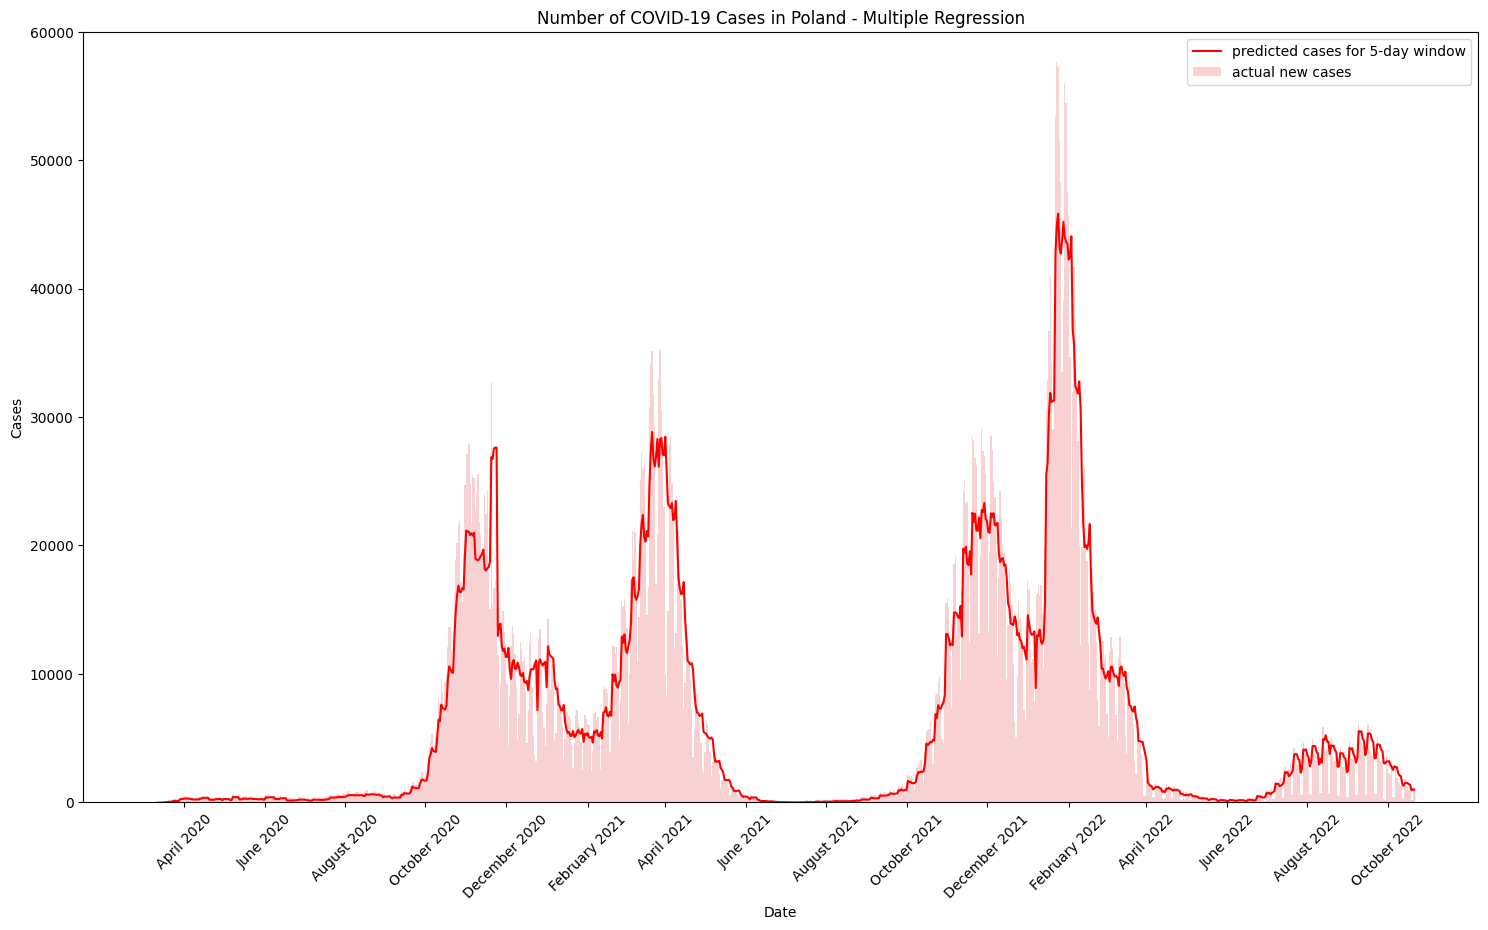

In [262]:
# Wykres przewidywanej liczby zakażeń dla najlepszego modelu regresji wielorakiej
best_regr_interval = min_rmse_interval(df_regr)
plot_predictions(df_pol, window_interval=best_regr_interval, pred_models=regr_models)

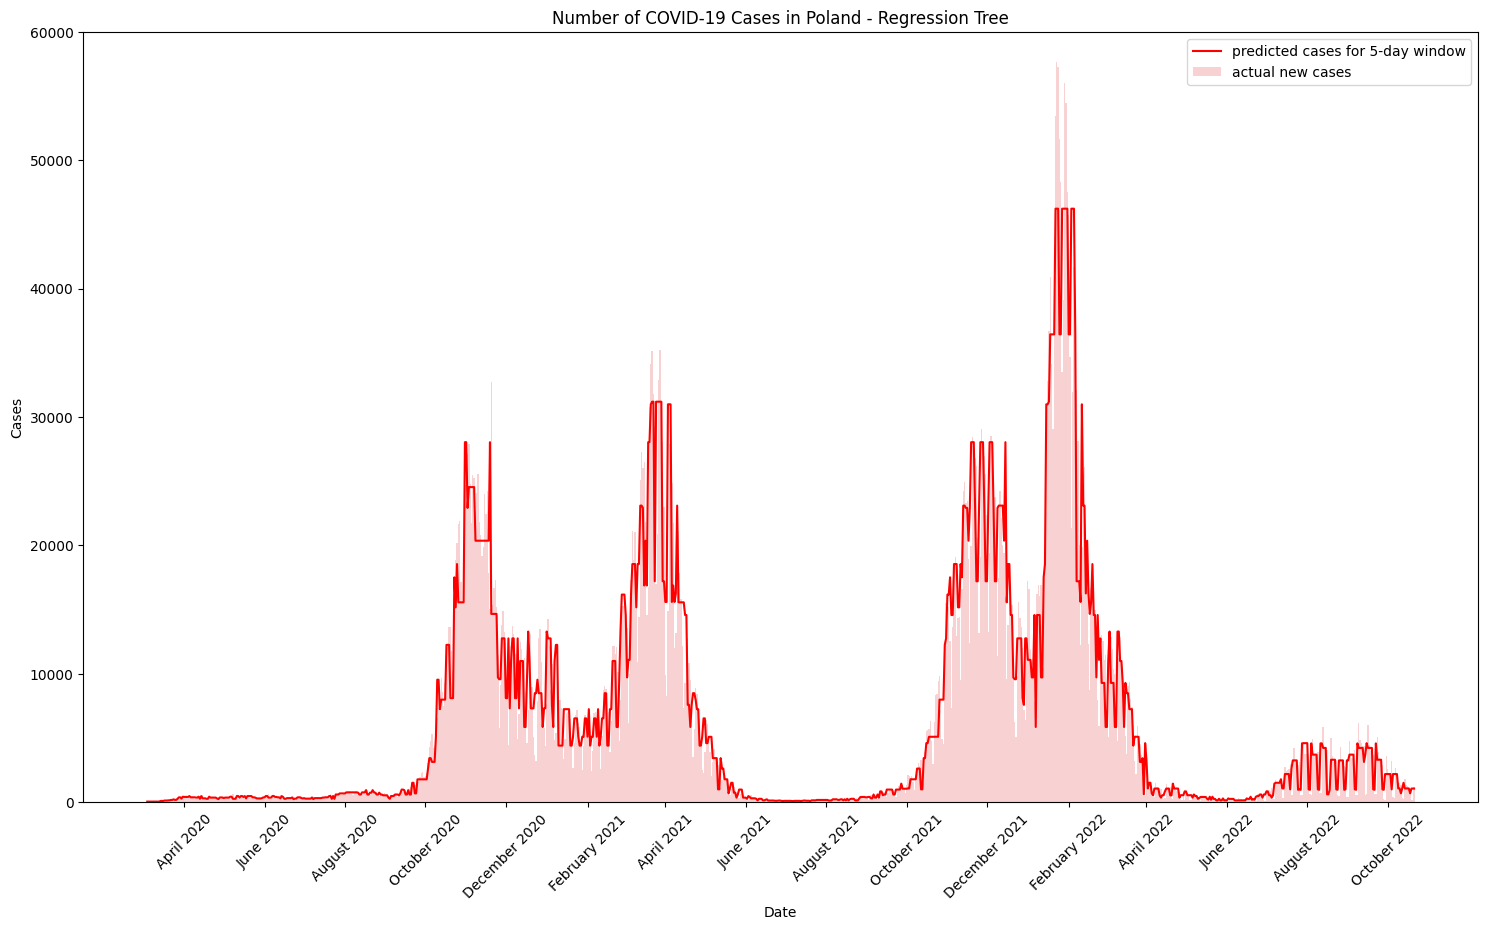

In [265]:
# Wykres przewidywanej liczby zakażeń dla najlepszego modelu drzewa regresyjnego
best_tree_interval = min_rmse_interval(df_tree)
plot_predictions(df_pol, window_interval=best_tree_interval, pred_models=tree_models)

31/31 [==============================] - 0s 4ms/step


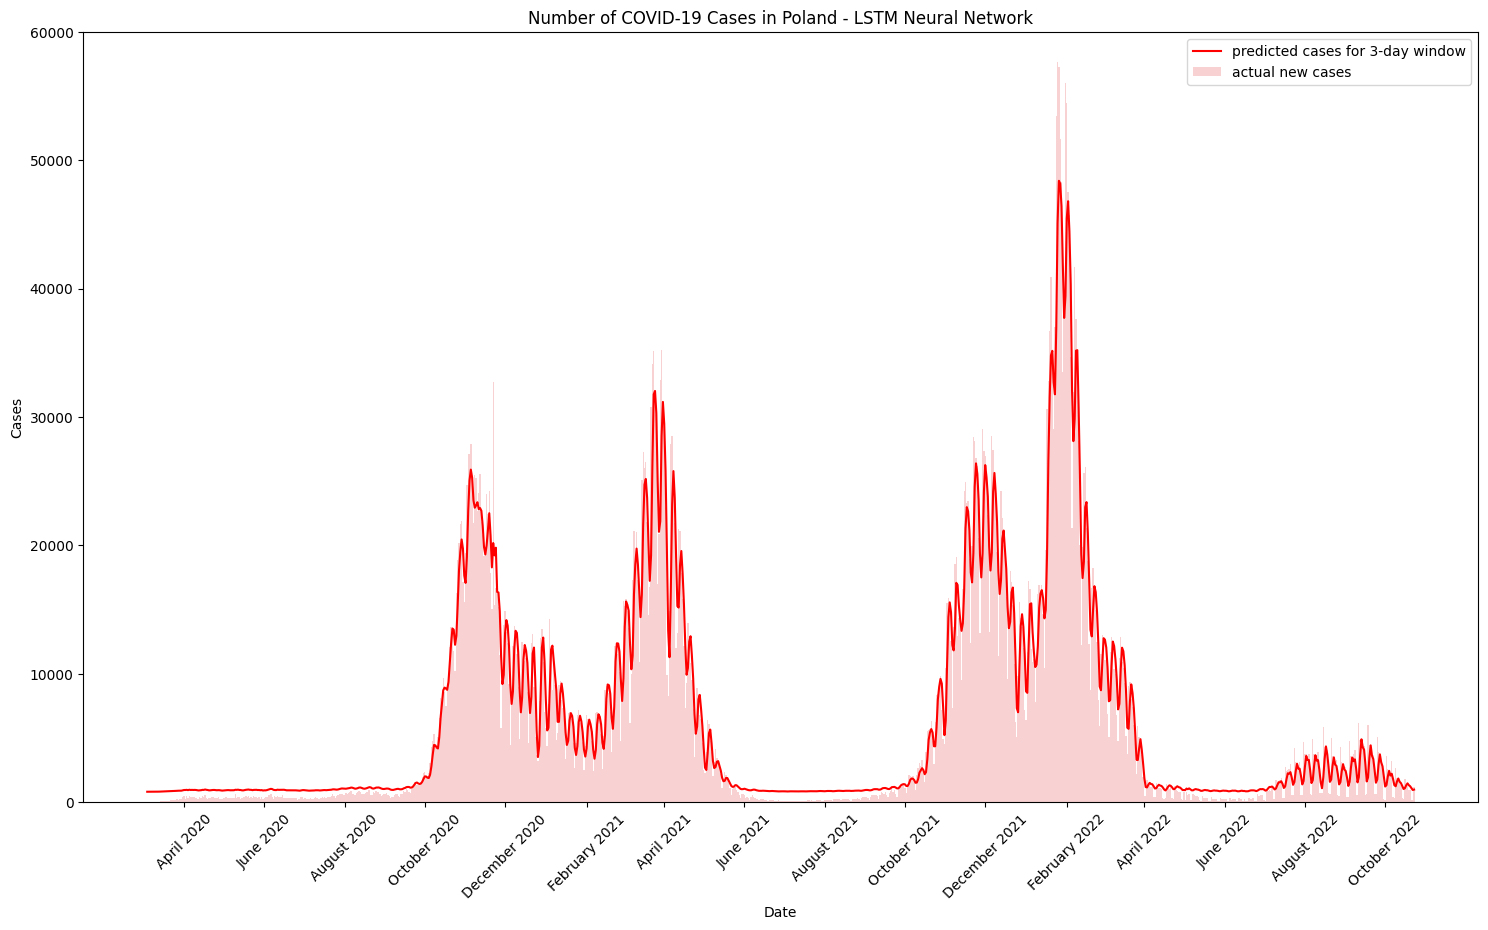

In [266]:
# Wykres przewidywanej liczby zakażeń dla najlepszego modelu sieci neuronowej LSTM
best_net_interval = min_rmse_interval(df_net)
plot_predictions(df_pol, window_interval=best_net_interval, pred_models=net_models)

Z uzyskanych modeli najmniejszy średni błąd kwadratowy RMSE osiągnął model drzewa decyzyjnego dla okna czasowego o długości 5 dni. Wykres predykcji tego modelu jest dobrze dopasowany do wykresu rzeczywistej liczby zakażeń. Umiarkowanie dobrze model ten przewiduje cykliczne spadki w liczbie zakażeń, wynikające z okresów weekendowych. Liczba przeprowadzanych testów w czasie weekendów, i tym samym liczba wykrytych nowych zakażeń, jest zwykle najmniejsza. Nieco gorzej pod tym względem wypada najlepszy model wśród modeli regresji wielorakiej (5-dniowe okno czasowe). Z kolei najlepszy model sieci neuronowej LSTM (3-dniowe okno czasowe) wyraźnie zawyża liczbę zakażeń w okresach, gdy rzeczywista ich liczba jest najmniejsza (od lutego 2020 do października 2020, od czerwca 2021 do paźdzernika 2021, oraz od kwietnia 2022 do lipca 2022).